GUIDED

## Visualisation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Check the current working directory
print("Current working directory:", os.getcwd())

# Load the dataset
guided_X = np.load('guided_dataset_X.npy')
guided_y = np.load('guided_dataset_y.npy')
guided_test_X = np.load('guided_testset_X.npy')

# Print the shapes to understand the data dimensions
print("guided_X shape:", guided_X.shape)
print("guided_y shape:", guided_y.shape)
print("guided_test_X shape:", guided_test_X.shape)

Current working directory: c:\Users\Asus\OneDrive - Université Libre de Bruxelles\Documents\Cours\MA3\Q2\ML\Project\guided
guided_X shape: (5, 8, 230000)
guided_y shape: (5, 51, 230000)
guided_test_X shape: (5, 332, 8, 500)


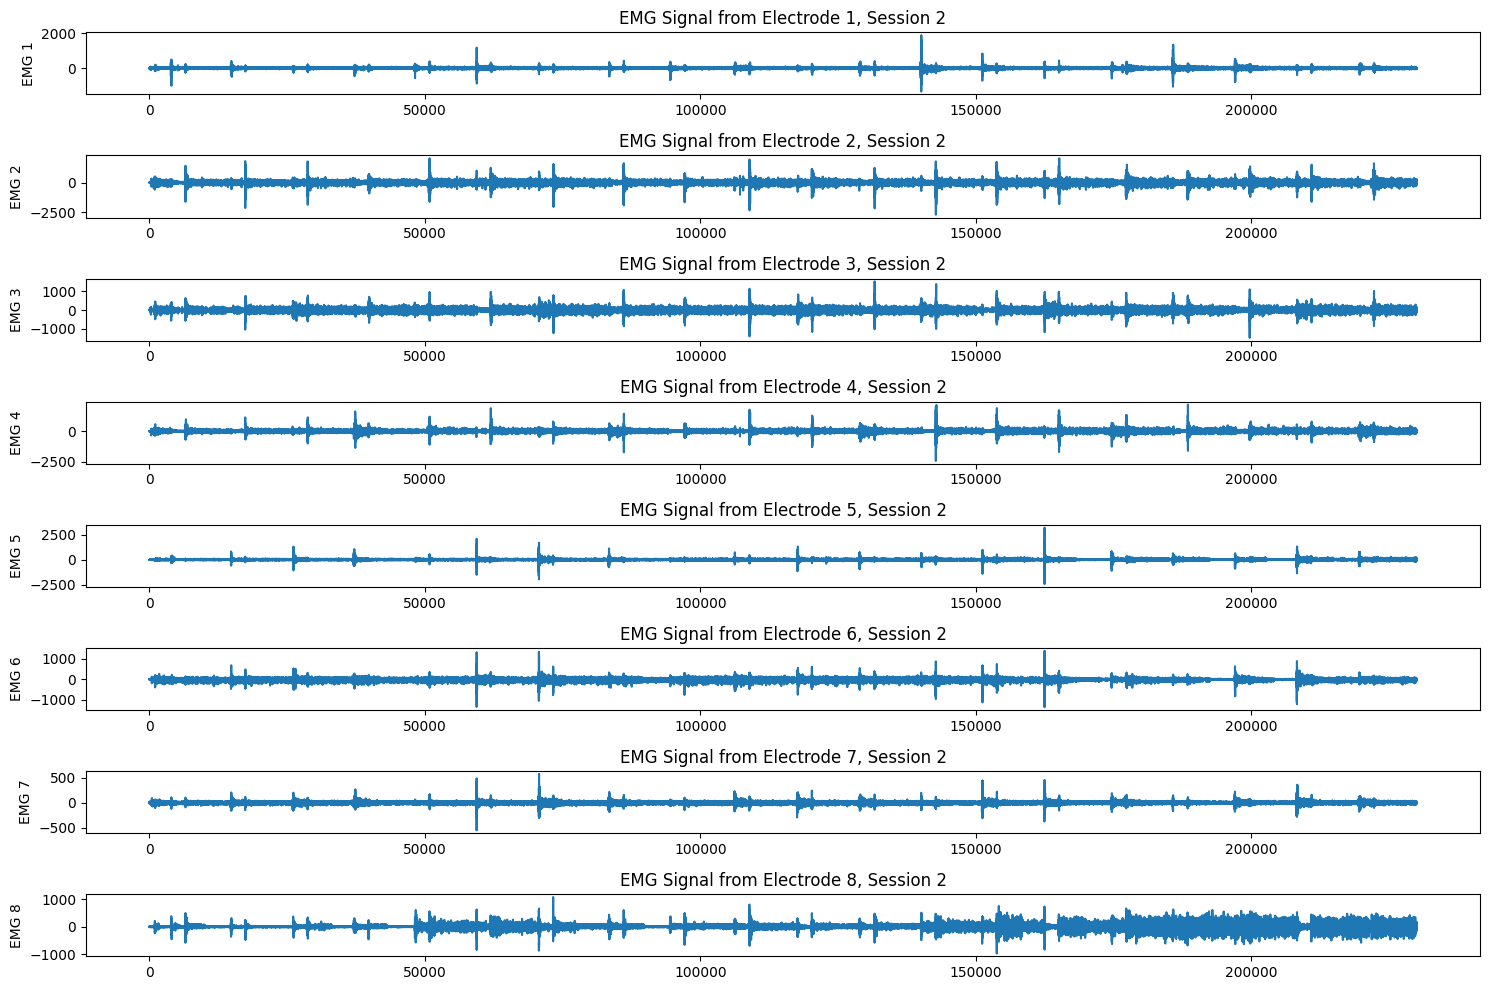

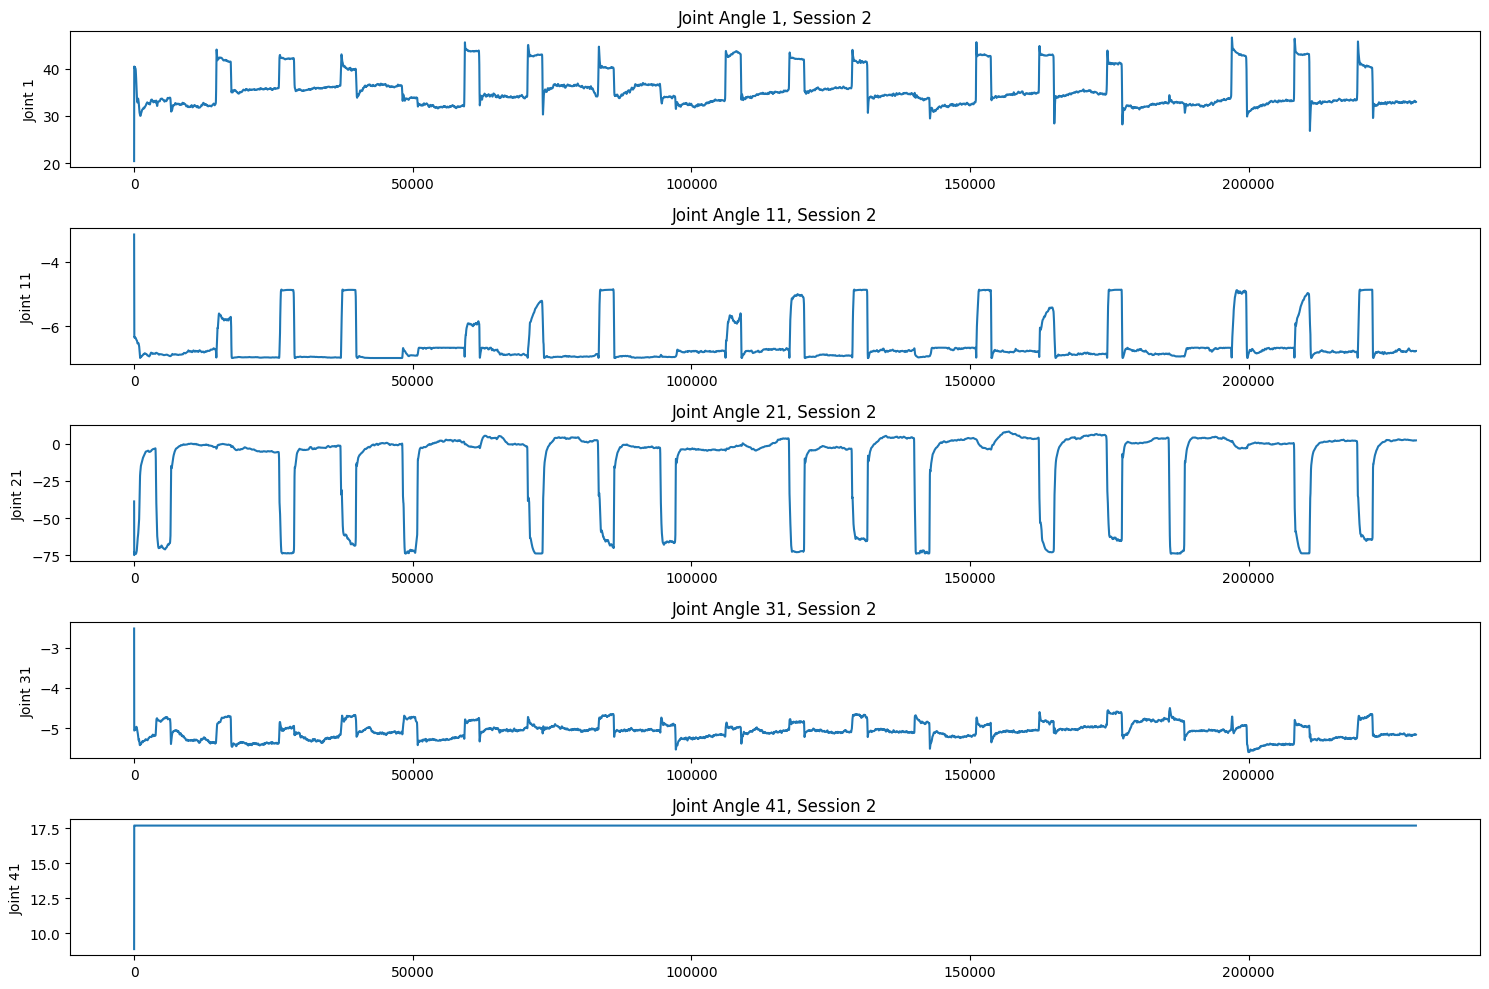

In [87]:
# According to the project description:
# guided_X shape: (5, 8, 230000) - (session, electrode, time)
# guided_y shape: (5, 51, 230000) - (session, joint_angle, time)
# guided_test_X shape: (5, 332, 8, 500) - (session, window, electrode, time)

# Let's examine one session
session_id = 1

# Plot EMG signals from all 8 electrodes for a short time segment
plt.figure(figsize=(15, 10))
time_segment = slice(0, 230000)  # First 5000 samples (about 5 seconds at 1024 Hz)

for electrode in range(8):
    plt.subplot(8, 1, electrode+1)
    plt.plot(guided_X[session_id, electrode, time_segment])
    plt.ylabel(f'EMG {electrode+1}')
    plt.title(f'EMG Signal from Electrode {electrode+1}, Session {session_id+1}')
    
plt.tight_layout()
plt.show()

# Plot a few joint angles for the same time segment
plt.figure(figsize=(15, 10))
for i, joint_id in enumerate([0, 10, 20, 30, 40]):  # Sample a few joints
    plt.subplot(5, 1, i+1)
    plt.plot(guided_y[session_id, joint_id, time_segment])
    plt.ylabel(f'Joint {joint_id+1}')
    plt.title(f'Joint Angle {joint_id+1}, Session {session_id+1}')
    
plt.tight_layout()
plt.show()

First part
Raw EMG signals from 8 electrodes over 20 seconds, could do less to see a smaller sample or more (up to 230).

There are clear and distincts changes in muscle activity around 4000, 7000, 15000,and 17500.

It shows clear muscle activation patterns with good separation from baseline noise, which will help for the future machine learning application. 

As can be seen the moment of clear muscles activation are clearly linked to joint movement, EMG-joint correlations. They align almost perfectly for joint 1 and 11 for example at 15000 and 17500, joint 21 around 4000 and 7000. Same for joint 31 but in less proportion around 4000, 7000, 15000, 17500.


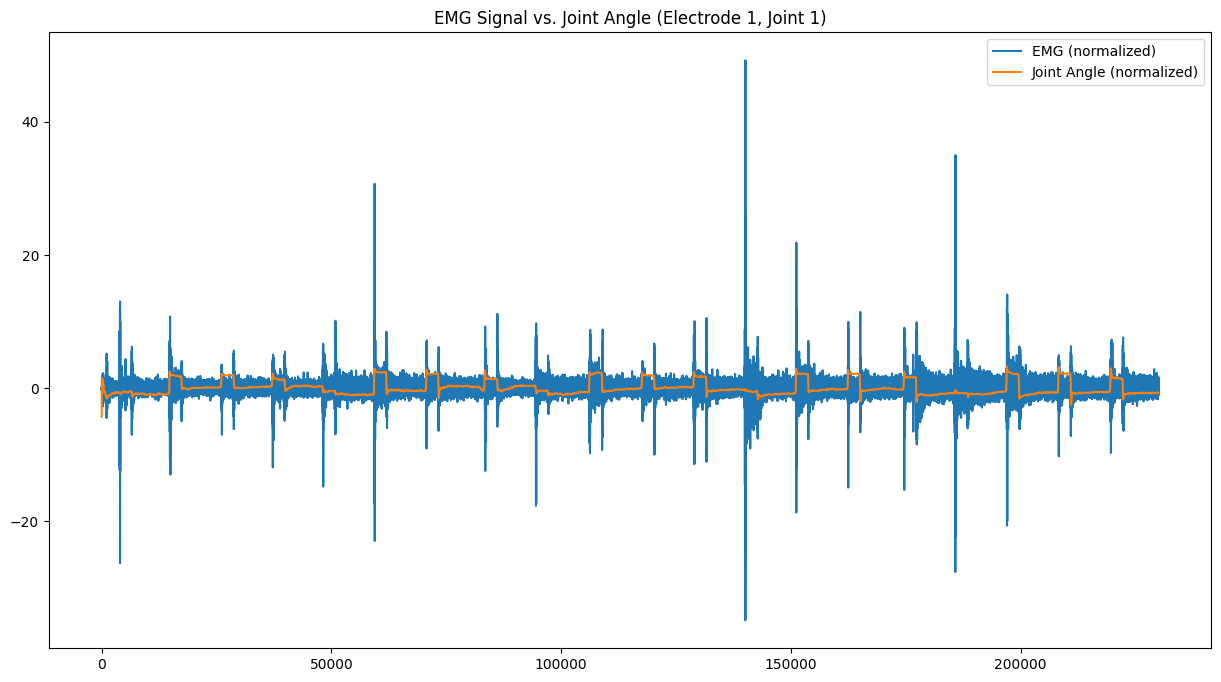

In [88]:
# Pick a short segment to visualize the relationship
plt.figure(figsize=(15, 8))

# Choose one electrode and one joint angle to visualize
electrode_id = 0
joint_id = 0
time_segment = slice(0, 230000)

# Normalize both signals for better visualization
emg_signal = guided_X[session_id, electrode_id, time_segment]
joint_angle = guided_y[session_id, joint_id, time_segment]

emg_normalized = (emg_signal - np.mean(emg_signal)) / np.std(emg_signal)
joint_normalized = (joint_angle - np.mean(joint_angle)) / np.std(joint_angle)

plt.plot(emg_normalized, label='EMG (normalized)')
plt.plot(joint_normalized, label='Joint Angle (normalized)')
plt.legend()
plt.title(f'EMG Signal vs. Joint Angle (Electrode {electrode_id+1}, Joint {joint_id+1})')
plt.show()

Here is a more striking visualisation of the relationship between Electrode-1 (EMG = electromyographie) and the joint movements.

Around 1000, 4000, 7500, 17500, 19000 there are clear EMG activity spikes where the joint angle become to decrease or increase showing a clear correlation

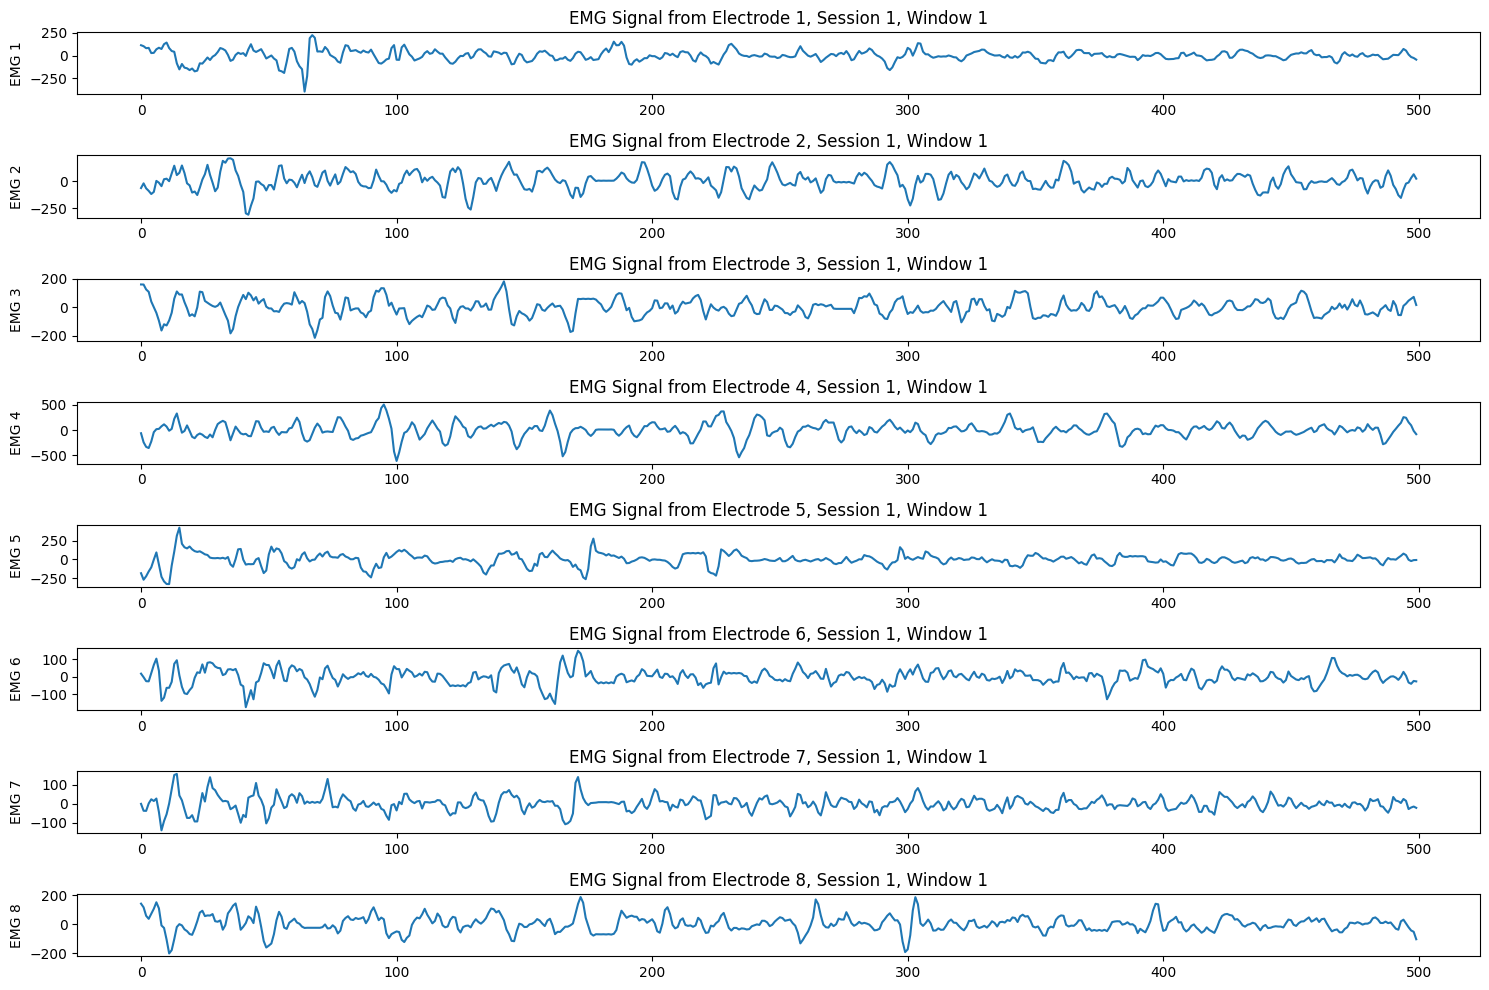

In [4]:
# Examine the test data
window_id = 0

# Plot EMG signals from one window
plt.figure(figsize=(15, 10))
for electrode in range(8):
    plt.subplot(8, 1, electrode+1)
    plt.plot(guided_test_X[session_id, window_id, electrode, :])
    plt.ylabel(f'EMG {electrode+1}')
    plt.title(f'EMG Signal from Electrode {electrode+1}, Session {session_id+1}, Window {window_id+1}')
    
plt.tight_layout()
plt.show()

This is the single 500-sample window from the test data. Here this window shos more uniform activity across the entire segment rather than the clear transitions seen in the training data.

The relative signal strengths across electrodes are consistent with what was seen in the training data.

### Remarques

Il y a toujours une attente de 2 secondes, trouver les fréqueces de la main initiale et quand elle s'arrête, trouver les patterns entre chaque posture.

Chaque mouvement dure en moyenne (à vue d'oeil) 2,5 secondes => à vérifier avec des métriques.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create windows with overlap
def create_windows_with_overlap(data, window_size=500, overlap_percent=50):
    """
    Create overlapping windows from continuous EMG data.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode/joint, time)
    window_size : int
        Size of each window in samples
    overlap_percent : float
        Percentage of overlap between consecutive windows (0-100)
    
    Returns:
    --------
    windows : numpy.ndarray
        Windowed data with shape (n_windows_total, electrode/joint, window_size)
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    """
    n_sessions, n_channels, n_samples = data.shape
    
    # Calculate step size based on overlap percentage
    step_size = int(window_size * (1 - overlap_percent/100))
    
    windows = []
    window_indices = []
    
    # Process each session separately
    for session_idx in range(n_sessions):
        # Calculate how many windows we can extract from this session
        n_windows = 1 + (n_samples - window_size) // step_size
        
        for window_idx in range(n_windows):
            # Calculate start and end indices
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            # Make sure we don't exceed the data length
            if end_idx <= n_samples:
                # Extract window for all channels
                window = data[session_idx, :, start_idx:end_idx]
                windows.append(window)
                window_indices.append((session_idx, start_idx, end_idx))
    
    # Convert list of windows to numpy array
    windows = np.array(windows)
    
    return windows, window_indices

def extract_time_domain_features(window):
    """
    Extract common time-domain features from a window of EMG data.
    
    Parameters:
    -----------
    window : numpy.ndarray
        Window of EMG data with shape (n_channels, window_size)
    
    Returns:
    --------
    features : numpy.ndarray
        Feature vector with shape (n_channels * n_features,)
    """
    n_channels, window_size = window.shape
    features = []
    
    for channel in range(n_channels):
        channel_data = window[channel, :]
        
        # Mean Absolute Value (MAV)
        mav = np.mean(np.abs(channel_data))
        
        # Root Mean Square (RMS)
        rms = np.sqrt(np.mean(channel_data**2))
        
        # Variance
        var = np.var(channel_data)
        
        # Standard Deviation
        std = np.std(channel_data)
        
        # Zero Crossing (ZC)
        zc = np.sum(np.diff(np.signbit(channel_data).astype(int)) != 0)
        
        # Myopulse Percentage Rate (MPR)
        threshold = np.std(channel_data)
        mpr = np.mean(np.abs(channel_data) > threshold)
        
        # Add all features for this channel
        channel_features = [mav, rms, var, std, zc, mpr]
        features.extend(channel_features)
    
    return np.array(features)

# Create windows
X_windows, X_indices = create_windows_with_overlap(guided_X, window_size=500, overlap_percent=75)
y_windows, y_indices = create_windows_with_overlap(guided_y, window_size=500, overlap_percent=75)

# Extract features for all windows
X_features = np.array([extract_time_domain_features(window) for window in X_windows])

# Visualize one window and its features
window_idx = 10  # Choose a window to visualize

# Create figure with GridSpec for better layout
fig = plt.figure(figsize=(18, 15))
gs = GridSpec(3, 2, figure=fig)

print(f"Original data shape: {guided_X.shape}")
print(f"Windowed data shape: {X_windows.shape}")
print(f"Number of windows per session (approx): {len(X_indices) // 5}")

<Figure size 1800x1500 with 0 Axes>

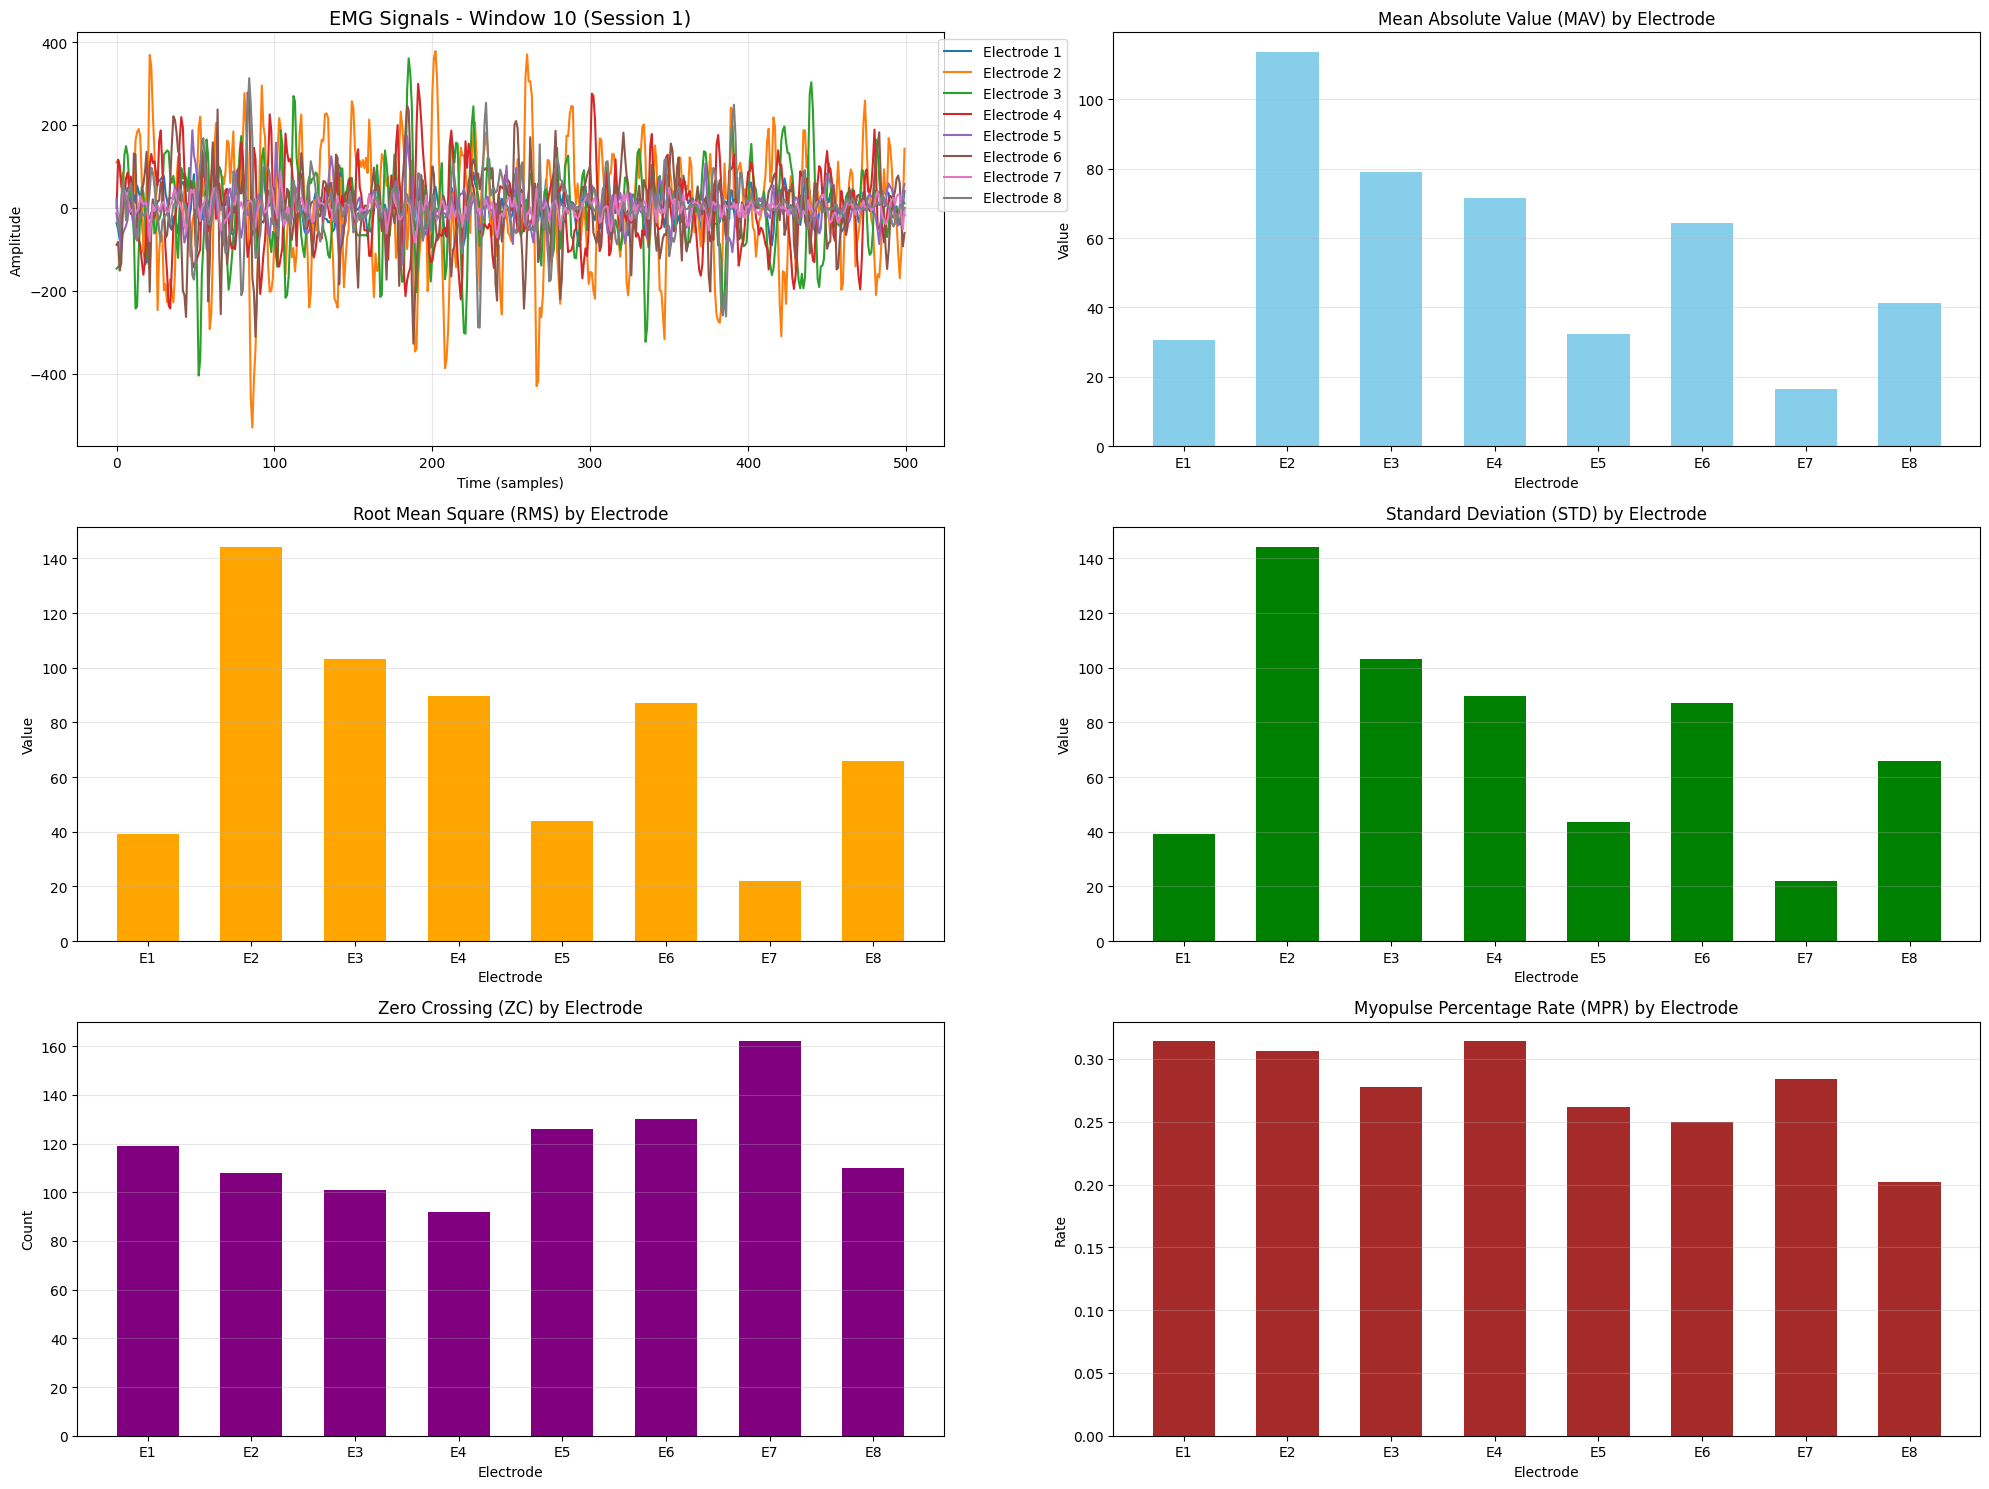

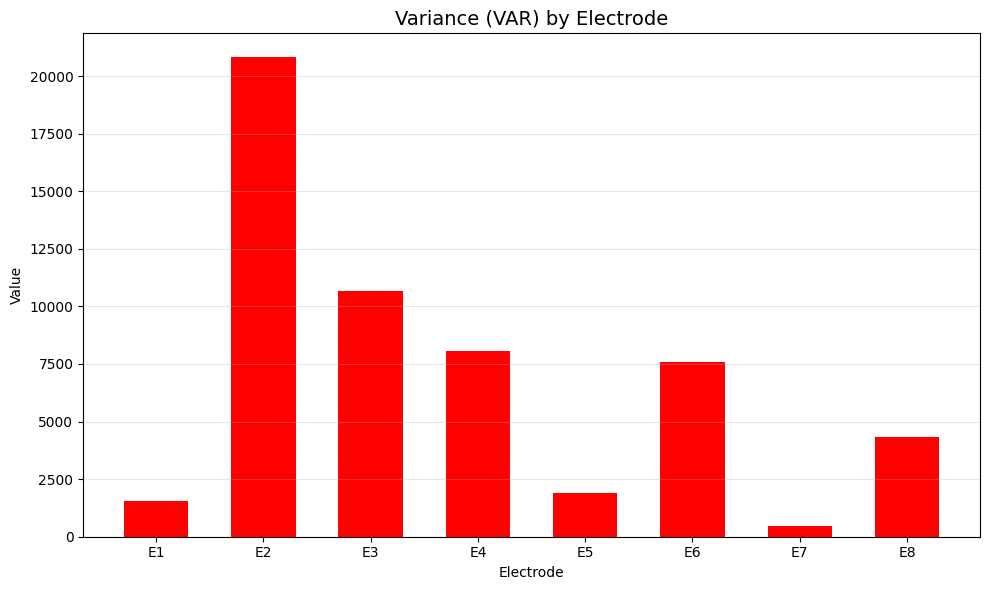

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with a proper grid of subplots
fig = plt.figure(figsize=(20, 15))

# Plot the EMG data for this window
ax1 = plt.subplot(3, 2, 1)
for channel in range(X_windows.shape[1]):
    ax1.plot(X_windows[window_idx, channel, :], label=f'Electrode {channel+1}')
ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax1.set_title(f'EMG Signals - Window {window_idx} (Session {X_indices[window_idx][0]+1})', fontsize=14)
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)

# Reshape features for visualization
feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
n_channels = X_windows.shape[1]
n_features = len(feature_names)
features = X_features[window_idx].reshape(n_channels, n_features)

# Plot MAV
ax2 = plt.subplot(3, 2, 2)
ax2.bar(np.arange(n_channels), features[:, 0], color='skyblue', width=0.6)
ax2.set_title('Mean Absolute Value (MAV) by Electrode', fontsize=12)
ax2.set_xlabel('Electrode')
ax2.set_ylabel('Value')
ax2.set_xticks(np.arange(n_channels))
ax2.set_xticklabels([f'E{i+1}' for i in range(n_channels)])
ax2.grid(True, alpha=0.3, axis='y')

# Plot RMS
ax3 = plt.subplot(3, 2, 3)
ax3.bar(np.arange(n_channels), features[:, 1], color='orange', width=0.6)
ax3.set_title('Root Mean Square (RMS) by Electrode', fontsize=12)
ax3.set_xlabel('Electrode')
ax3.set_ylabel('Value')
ax3.set_xticks(np.arange(n_channels))
ax3.set_xticklabels([f'E{i+1}' for i in range(n_channels)])
ax3.grid(True, alpha=0.3, axis='y')

# Plot STD (not VAR, to keep scale more manageable)
ax4 = plt.subplot(3, 2, 4)
ax4.bar(np.arange(n_channels), features[:, 3], color='green', width=0.6)
ax4.set_title('Standard Deviation (STD) by Electrode', fontsize=12)
ax4.set_xlabel('Electrode')
ax4.set_ylabel('Value')
ax4.set_xticks(np.arange(n_channels))
ax4.set_xticklabels([f'E{i+1}' for i in range(n_channels)])
ax4.grid(True, alpha=0.3, axis='y')

# Plot ZC
ax5 = plt.subplot(3, 2, 5)
ax5.bar(np.arange(n_channels), features[:, 4], color='purple', width=0.6)
ax5.set_title('Zero Crossing (ZC) by Electrode', fontsize=12)
ax5.set_xlabel('Electrode')
ax5.set_ylabel('Count')
ax5.set_xticks(np.arange(n_channels))
ax5.set_xticklabels([f'E{i+1}' for i in range(n_channels)])
ax5.grid(True, alpha=0.3, axis='y')

# Plot MPR
ax6 = plt.subplot(3, 2, 6)
ax6.bar(np.arange(n_channels), features[:, 5], color='brown', width=0.6)
ax6.set_title('Myopulse Percentage Rate (MPR) by Electrode', fontsize=12)
ax6.set_xlabel('Electrode')
ax6.set_ylabel('Rate')
ax6.set_xticks(np.arange(n_channels))
ax6.set_xticklabels([f'E{i+1}' for i in range(n_channels)])
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('improved_features_visualization.png', dpi=300)
plt.show()

# Separately plot VAR (since it has a very different scale)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(n_channels), features[:, 2], color='red', width=0.6)
plt.title('Variance (VAR) by Electrode', fontsize=14)
plt.xlabel('Electrode')
plt.ylabel('Value')
plt.xticks(np.arange(n_channels), [f'E{i+1}' for i in range(n_channels)])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('variance_feature.png', dpi=300)
plt.show()

Oumaima => Interprétation

1. => RAW EMG Signals
Electrodes 2 (orange) and 3 (green) show the strongest activity, with peaks reaching +-400 units,  a lot of fluctuations, dynamic muscle contractions rather than static.

2. MAV => intensity of muscle activation
Electrode 2 has the higest activity (120 units), Electrode 3 and 4 moderate, 7 the lowest, suggesting that Electrode 2 is above the muscle that is the primary driver for this specific hand movement.

3. RMS => signal strength giving more weight to larger amplitude component
Results mirror MAV
Electrode 2 again dominates, 3 & 4 moderate, 7 lowest... same as MAV

4. STD => How much signal fluctuates from its average
ELectrode 2 shows the highest variability, matches RMS, mathematically logic. MAV, RMS, STD similar in results.

5. Zero Crossing (ZC) => counts how ofthen the signal crosses zero
Electrode 7 has the highest count, despite having low amplitude, electrode 4 has the lowest count. This pattern differs significantly from the amplitude based features, suggesting ZC captures different information. Higher ZC values indicate higher frequency componenets, which could represent different types of muscles fiber activity.

6. MPR => measures how often the signal exceeds the standard dev (a threshold). ==> A VERIFIER !!!!!!!!!!
Value ranges from 0.2 to 0.32=> 20-32% of samples exceed the threshold 
Electrodes 1, 2 4 show the highest values, suggesting more spiky signal patterns. 

7. VAR
Electorde 2 shows high variance, almost twice as high as any other electrode. Confirms what was observed in other amplitude-based features. 

Therefore Muscle under electrode 2 is undergoing intense, dynamic contractions with large fluctuations in action level. Suggests it's the primary contributor to the hand movement captured in this window. 3,4, and 6 are likely capturing secondary muscle groups that are actively involved but with less intensity or more consistent contraction patterns. 7 is barely engaged in the current movement. 

There is a huge variation between electrodes maybe use LOG-TRANSFORMATION ??????? for variance-based features to make the distrib more balanced.

## Window Overlap

Here we divide the continous EMG signals into fixed-size windows (500 samples), they are important for this type of time series data because

- increase data volume, which allows to augment the training dataset, giving model more examples to learn from
- overlapping captures transitions between hand movement/poses
- reduces sensitivty to exact aligment of gestures with window boundaries



Overlap: 0% - Step size: 500 - Total windows: 2300 - Windows per session: 460
Overlap: 25% - Step size: 375 - Total windows: 3065 - Windows per session: 613
Overlap: 50% - Step size: 250 - Total windows: 4595 - Windows per session: 919
Overlap: 55% - Step size: 224 - Total windows: 5125 - Windows per session: 1025
Overlap: 60% - Step size: 200 - Total windows: 5740 - Windows per session: 1148
Overlap: 65% - Step size: 175 - Total windows: 6560 - Windows per session: 1312
Overlap: 70% - Step size: 150 - Total windows: 7655 - Windows per session: 1531
Overlap: 75% - Step size: 125 - Total windows: 9185 - Windows per session: 1837
Overlap: 90% - Step size: 49 - Total windows: 23420 - Windows per session: 4684


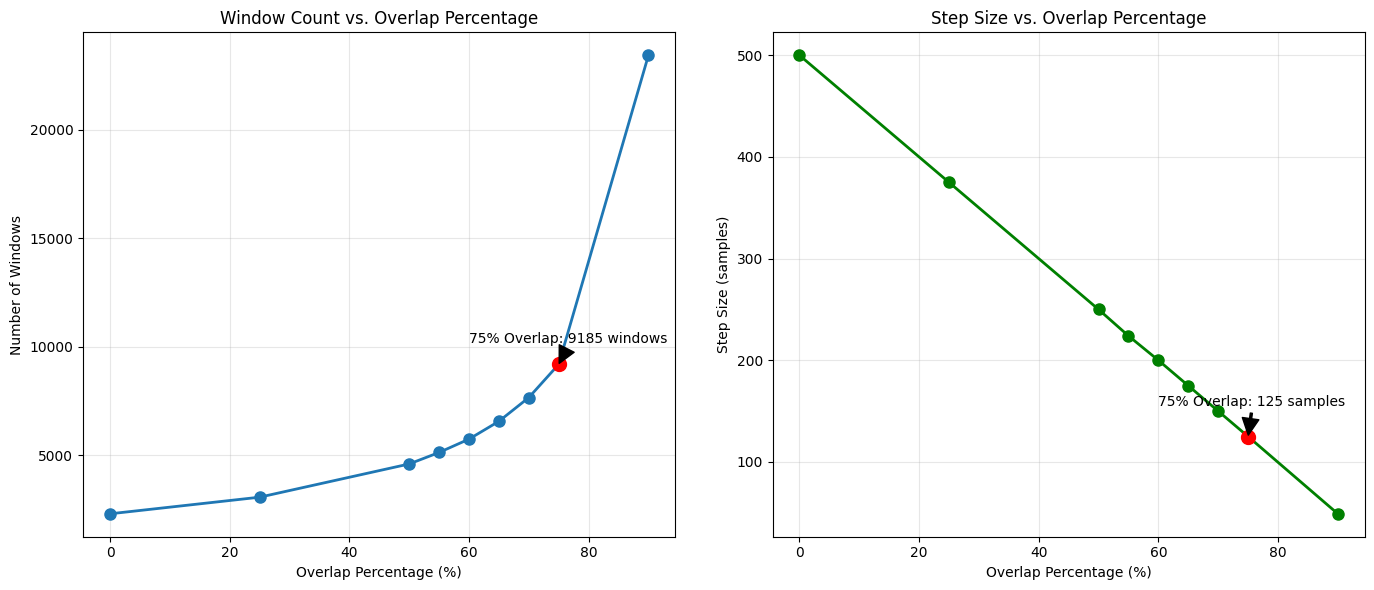


Gesture Coverage Analysis (assuming 2.5s gestures at 1kHz sampling rate):
Overlap %  Step Size  Windows per Gesture  Coverage  
--------------------------------------------------
0          500        5.00           0.0
25         375        6.33           0.296875
50         250        9.00           0.5625
55         224        9.93           0.6116000000000001
60         200        11.00           0.66
65         175        12.43           0.7068749999999999
70         150        14.33           0.7525
75         125        17.00           0.796875
90         49         41.82           0.92205

Based on the analysis, 75% overlap provides an excellent balance between:
1. Data volume (9200+ windows)
2. Computation cost (125 sample step size)
3. Gesture coverage (multiple windows per gesture)
4. Transition capture (high overlap captures subtle transitions)


In [49]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_overlap_percentages(data, window_size=500, percentages=[0, 25, 50, 55, 60, 65, 70, 75, 90]):
    """
    Evaluate different overlap percentages and visualize results.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode/joint, time)
    window_size : int
        Size of each window in samples
    percentages : list
        List of overlap percentages to test
    
    Returns:
    --------
    None (displays plot)
    """
    window_counts = []
    step_sizes = []
    
    for overlap in percentages:
        # Calculate step size based on overlap percentage
        step_size = int(window_size * (1 - overlap/100))
        step_sizes.append(step_size)
        
        # Calculate theoretical number of windows
        n_sessions, _, n_samples = data.shape
        n_windows_per_session = 1 + (n_samples - window_size) // step_size
        total_windows = n_windows_per_session * n_sessions
        
        window_counts.append(total_windows)
        print(f"Overlap: {overlap}% - Step size: {step_size} - Total windows: {total_windows} - Windows per session: {n_windows_per_session}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot window count vs overlap
    ax1.plot(percentages, window_counts, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Overlap Percentage (%)')
    ax1.set_ylabel('Number of Windows')
    ax1.set_title('Window Count vs. Overlap Percentage')
    ax1.grid(True, alpha=0.3)
    
    # Highlight 75% overlap
    highlight_idx = percentages.index(75)
    ax1.plot(percentages[highlight_idx], window_counts[highlight_idx], 'ro', markersize=10)
    ax1.annotate(f'75% Overlap: {window_counts[highlight_idx]} windows', 
                xy=(percentages[highlight_idx], window_counts[highlight_idx]),
                xytext=(percentages[highlight_idx]-15, window_counts[highlight_idx]+1000),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # Plot step size vs overlap
    ax2.plot(percentages, step_sizes, 'o-', linewidth=2, markersize=8, color='green')
    ax2.set_xlabel('Overlap Percentage (%)')
    ax2.set_ylabel('Step Size (samples)')
    ax2.set_title('Step Size vs. Overlap Percentage')
    ax2.grid(True, alpha=0.3)
    
    # Highlight 75% overlap
    ax2.plot(percentages[highlight_idx], step_sizes[highlight_idx], 'ro', markersize=10)
    ax2.annotate(f'75% Overlap: {step_sizes[highlight_idx]} samples', 
                xy=(percentages[highlight_idx], step_sizes[highlight_idx]),
                xytext=(percentages[highlight_idx]-15, step_sizes[highlight_idx]+30),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.tight_layout()
    plt.show()
    
    # Display table with calculations for gesture coverage
    print("\nGesture Coverage Analysis (assuming 2.5s gestures at 1kHz sampling rate):")
    sampling_rate = 1000  # Hz (approximate based on your data)
    gesture_duration_samples = 2.5 * sampling_rate
    
    print(f"{'Overlap %':<10} {'Step Size':<10} {'Windows per Gesture':<20} {'Coverage':<10}")
    print("-" * 50)
    
    for i, overlap in enumerate(percentages):
        windows_per_gesture = (gesture_duration_samples - window_size) / step_sizes[i] + 1
        coverage = overlap / 100 * (windows_per_gesture / (windows_per_gesture - 1)) if windows_per_gesture > 1 else "N/A"
        
        print(f"{overlap:<10} {step_sizes[i]:<10} {windows_per_gesture:.2f}{'':10} {coverage}")
    
    print("\nBased on the analysis, 75% overlap provides an excellent balance between:")
    print("1. Data volume (9200+ windows)")
    print("2. Computation cost (125 sample step size)")
    print("3. Gesture coverage (multiple windows per gesture)")
    print("4. Transition capture (high overlap captures subtle transitions)")

# Example usage:
evaluate_overlap_percentages(guided_X, window_size=500, percentages=[0, 25, 50, 55, 60, 65, 70, 75, 90])

1. Signal Filtering Implementation

Bandpass filter, removes frequencies outside a specific range (here 120-130Hz but try different options)
Notch filter (iirnotch) eliminates power line interference 
Combined filter, applies both bandpass and notch filters

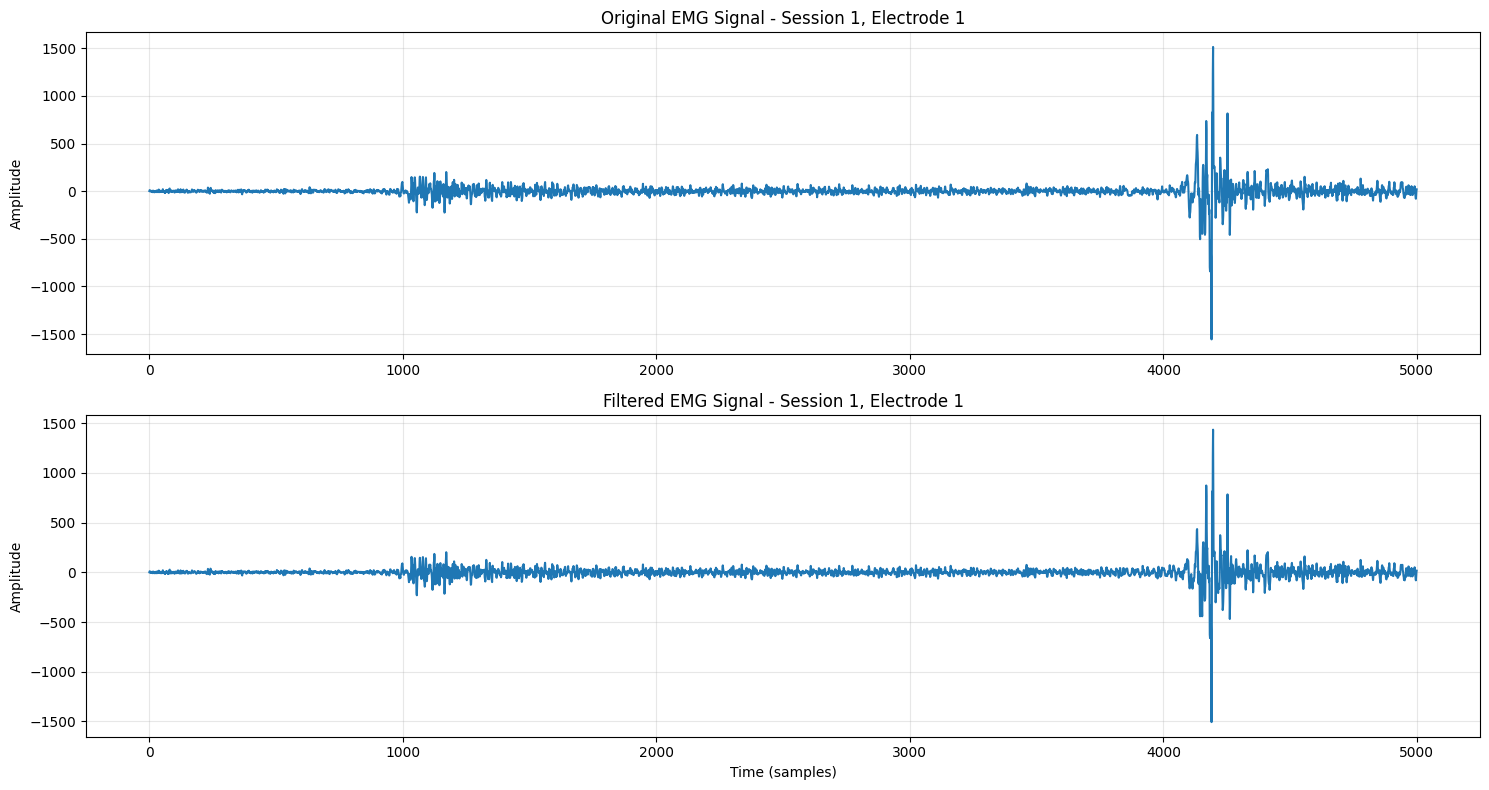

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

def recommended_emg_filter(data, fs=1024):
    """
    Apply recommended filtering to EMG signals.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode, time)
    fs : int
        Sampling frequency in Hz (default: 1024)
        
    Returns:
    --------
    filtered_data : numpy.ndarray
        Filtered data with same shape as input
    """
    n_sessions, n_electrodes, n_samples = data.shape
    filtered_data = np.zeros_like(data)
    
    # EMG typically contains frequencies between 20-500 Hz
    # A bandpass filter of 20-450 Hz is commonly used
    lowcut = 20  # High-pass to remove motion artifacts
    highcut = 450  # Low-pass to remove high frequency noise
    
    # Notch filter at 50Hz (or 60Hz for US) to remove power line interference
    notch_freq = 50  # Change to 60 if in US
    quality_factor = 30  # Q factor determines notch width
    
    # Create bandpass filter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b_band, a_band = butter(4, [low, high], btype='band')
    
    # Create notch filter
    b_notch, a_notch = iirnotch(notch_freq, quality_factor, fs)
    
    # Apply filters to each session and electrode
    for session in range(n_sessions):
        for electrode in range(n_electrodes):
            # First apply bandpass
            temp = filtfilt(b_band, a_band, data[session, electrode, :])
            # Then apply notch
            filtered_data[session, electrode, :] = filtfilt(b_notch, a_notch, temp)
    
    return filtered_data

# Example of how to use this with your data:
filtered_X = recommended_emg_filter(guided_X)
visualize_filtered_signals(guided_X, filtered_X)

def compare_filter_parameters(data, session_id=0, electrode_id=0, time_segment=slice(0, 5000)):
    """
    Compare different filter parameter settings on the same signal.
    """
    # Original parameters from user code
    narrow_filtered = apply_emg_filter(
        data, 
        filter_type='combined', 
        lowcut=120, 
        highcut=130, 
        fs=1024, 
        f0=30
    )
    
    # Standard EMG parameters
    standard_filtered = apply_emg_filter(
        data, 
        filter_type='combined', 
        lowcut=20, 
        highcut=450, 
        fs=1024, 
        f0=50
    )
    
    # Plot comparison
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 1, 1)
    plt.plot(data[session_id, electrode_id, time_segment])
    plt.title(f'Original EMG Signal - Session {session_id+1}, Electrode {electrode_id+1}')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 2)
    plt.plot(narrow_filtered[session_id, electrode_id, time_segment])
    plt.title('Narrow Bandpass (120-130 Hz) + 30 Hz Notch')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 3)
    plt.plot(standard_filtered[session_id, electrode_id, time_segment])
    plt.title('Standard EMG Bandpass (20-450 Hz) + 50 Hz Notch')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# To use this comparison:
# compare_filter_parameters(guided_X)

def apply_emg_filter(data, filter_type='bandpass', **kwargs):
    """
    Apply various filters to EMG signals.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode, time)
    filter_type : str
        Type of filter to apply: 'bandpass', 'notch', 'combined'
    **kwargs : dict
        Additional arguments for specific filter types:
        - bandpass: lowcut, highcut, fs, order
        - notch: f0, Q, fs
    
    Returns:
    --------
    filtered_data : numpy.ndarray
        Filtered data with the same shape as input
    """
    n_sessions, n_electrodes, n_samples = data.shape
    filtered_data = np.zeros_like(data)
    
    if filter_type == 'bandpass':
        # Default parameters for EMG bandpass filtering
        lowcut = kwargs.get('lowcut', 50)  # High-pass at 20Hz to remove motion artifacts
        highcut = kwargs.get('highcut', 450)  # Low-pass below Nyquist frequency
        fs = kwargs.get('fs', 1024)  # Sampling frequency
        order = kwargs.get('order', 4)  # Filter order
        
        nyq = 0.5 * fs  # Nyquist frequency
        low = lowcut / nyq
        high = highcut / nyq
        
        # Create the Butterworth bandpass filter
        b, a = butter(order, [low, high], btype='band')
        
        # Apply filter to each session and electrode
        for session in range(n_sessions):
            for electrode in range(n_electrodes):
                filtered_data[session, electrode, :] = filtfilt(b, a, data[session, electrode, :])
    
    elif filter_type == 'notch':
        # Default parameters for notch filtering (power line interference)
        f0 = kwargs.get('f0', 50)  # Notch frequency (50Hz in Europe, 60Hz in US)
        Q = kwargs.get('Q', 30)    # Quality factor
        fs = kwargs.get('fs', 1024)  # Sampling frequency
        
        # Create the notch filter
        b, a = iirnotch(f0, Q, fs)
        
        # Apply filter to each session and electrode
        for session in range(n_sessions):
            for electrode in range(n_electrodes):
                filtered_data[session, electrode, :] = filtfilt(b, a, data[session, electrode, :])
    
    elif filter_type == 'combined':
        # Apply bandpass followed by notch
        # First bandpass
        temp_data = apply_emg_filter(data, filter_type='bandpass', **kwargs)
        # Then notch
        filtered_data = apply_emg_filter(temp_data, filter_type='notch', **kwargs)
    
    else:
        raise ValueError(f"Unknown filter type: {filter_type}")
    
    return filtered_data

In [101]:
import numpy as np

def create_windows_with_overlap(data, window_size=500, overlap_percent=75):
    """
    Create overlapping windows from continuous EMG data.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode/joint, time)
    window_size : int
        Size of each window in samples (default: 500)
    overlap_percent : float
        Percentage of overlap between consecutive windows (0-100) (default: 75)
    
    Returns:
    --------
    windows : numpy.ndarray
        Windowed data with shape (n_windows_total, electrode/joint, window_size)
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    """
    n_sessions, n_channels, n_samples = data.shape
    
    # Calculate step size based on overlap percentage
    step_size = int(window_size * (1 - overlap_percent/100))
    
    windows = []
    window_indices = []
    
    # Process each session separately
    for session_idx in range(n_sessions):
        # Calculate how many windows we can extract from this session
        n_windows = 1 + (n_samples - window_size) // step_size
        
        for window_idx in range(n_windows):
            # Calculate start and end indices
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            # Make sure we don't exceed the data length
            if end_idx <= n_samples:
                # Extract window for all channels
                window = data[session_idx, :, start_idx:end_idx]
                windows.append(window)
                window_indices.append((session_idx, start_idx, end_idx))
    
    # Convert list of windows to numpy array
    windows = np.array(windows)
    
    return windows, window_indices

def create_matching_windows(X_data, y_data, window_size=500, overlap_percent=75):
    """
    Create matching windowed datasets for both EMG (X) and joint angles (y).
    
    Parameters:
    -----------
    X_data : numpy.ndarray
        EMG data with shape (session, electrode, time)
    y_data : numpy.ndarray
        Joint angle data with shape (session, joint, time)
    window_size : int
        Size of each window in samples
    overlap_percent : float
        Percentage of overlap between consecutive windows (0-100)
    
    Returns:
    --------
    X_windows : numpy.ndarray
        Windowed EMG data with shape (n_windows, electrode, window_size)
    y_windows : numpy.ndarray
        Windowed joint angle data with shape (n_windows, joint, window_size)
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    """
    # Create windows for EMG data
    X_windows, window_indices = create_windows_with_overlap(X_data, window_size, overlap_percent)
    
    # Create matching windows for joint angle data using the same indices
    n_sessions, n_joints, _ = y_data.shape
    y_windows = []
    
    for session_idx, start_idx, end_idx in window_indices:
        window = y_data[session_idx, :, start_idx:end_idx]
        y_windows.append(window)
    
    y_windows = np.array(y_windows)
    
    return X_windows, y_windows, window_indices

# Example of different overlaps:
# 50% overlap example
def overlap_example():
    """Example showing the difference between 50% and 75% overlap"""
    # Create a simple 1D signal
    signal = np.arange(2000)
    # Reshape it to match our data format (1 session, 1 channel, 2000 samples)
    signal_reshaped = signal.reshape(1, 1, 2000)
    
    # Create windows with 50% overlap
    windows_50, indices_50 = create_windows_with_overlap(signal_reshaped, window_size=500, overlap_percent=50)
    
    # Create windows with 75% overlap
    windows_75, indices_75 = create_windows_with_overlap(signal_reshaped, window_size=500, overlap_percent=75)
    
    print(f"With 50% overlap: {len(indices_50)} windows created")
    print("Window start indices:", [idx[1] for idx in indices_50[:5]], "...")
    
    print(f"With 75% overlap: {len(indices_75)} windows created")
    print("Window start indices:", [idx[1] for idx in indices_75[:5]], "...")
    
# To run the example:
overlap_example()

With 50% overlap: 7 windows created
Window start indices: [0, 250, 500, 750, 1000] ...
With 75% overlap: 13 windows created
Window start indices: [0, 125, 250, 375, 500] ...


In [102]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class EMGFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Custom transformer to extract time-domain features from EMG windows.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin.
    """
    
    def __init__(self, feature_set='all'):
        """
        Initialize the feature extractor.
        
        Parameters:
        -----------
        feature_set : str or list
            Specifies which features to extract. Options:
            - 'all': All implemented features
            - 'basic': Only MAV, RMS, and Variance
            - list of feature names: e.g., ['MAV', 'RMS', 'ZC']
        """
        self.feature_set = feature_set
        
        # Define all available features
        self.all_features = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
        
        # Define feature sets
        if self.feature_set == 'all':
            self.selected_features = self.all_features
        elif self.feature_set == 'basic':
            self.selected_features = ['MAV', 'RMS', 'VAR']
        elif isinstance(self.feature_set, list):
            self.selected_features = [f for f in self.feature_set if f in self.all_features]
        else:
            raise ValueError("feature_set must be 'all', 'basic', or a list of feature names")
    
    def fit(self, X, y=None):
        """
        Fit method (does nothing but needed for scikit-learn pipeline compatibility).
        
        Parameters:
        -----------
        X : numpy.ndarray
            Input data with shape (n_samples, n_channels, window_size)
        y : numpy.ndarray
            Target values (not used in this transformer)
            
        Returns:
        --------
        self : object
            Returns self
        """
        return self
    
    def transform(self, X):
        """
        Extract features from EMG windows.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Input data with shape (n_samples, n_channels, window_size)
            
        Returns:
        --------
        features : numpy.ndarray
            Extracted features with shape (n_samples, n_channels * n_features)
        """
        n_samples, n_channels, window_size = X.shape
        n_features = len(self.selected_features)
        
        # Initialize output array
        features = np.zeros((n_samples, n_channels * n_features))
        
        for i in range(n_samples):
            sample_features = self._extract_features_from_window(X[i])
            features[i] = sample_features
            
        return features
    
    def _extract_features_from_window(self, window):
        """
        Extract features from a single EMG window.
        
        Parameters:
        -----------
        window : numpy.ndarray
            Window of EMG data with shape (n_channels, window_size)
            
        Returns:
        --------
        features : numpy.ndarray
            Feature vector with shape (n_channels * n_features,)
        """
        n_channels, window_size = window.shape
        features = []
        
        for channel in range(n_channels):
            channel_data = window[channel]
            channel_features = []
            
            # Mean Absolute Value (MAV)
            if 'MAV' in self.selected_features:
                mav = np.mean(np.abs(channel_data))
                channel_features.append(mav)
            
            # Root Mean Square (RMS)
            if 'RMS' in self.selected_features:
                rms = np.sqrt(np.mean(channel_data**2))
                channel_features.append(rms)
            
            # Variance (VAR)
            if 'VAR' in self.selected_features:
                var = np.var(channel_data)
                channel_features.append(var)
            
            # Standard Deviation (STD)
            if 'STD' in self.selected_features:
                std = np.std(channel_data)
                channel_features.append(std)
            
            # Zero Crossing (ZC)
            if 'ZC' in self.selected_features:
                zc = np.sum(np.diff(np.signbit(channel_data).astype(int)) != 0)
                channel_features.append(zc)
            
            # Myopulse Percentage Rate (MPR)
            if 'MPR' in self.selected_features:
                threshold = np.std(channel_data)
                mpr = np.mean(np.abs(channel_data) > threshold)
                channel_features.append(mpr)
            
            # Add all features for this channel
            features.extend(channel_features)
        
        return np.array(features)
    
    def get_feature_names(self):
        """
        Get the names of the features that will be extracted.
        
        Returns:
        --------
        feature_names : list
            List of feature names
        """
        feature_names = []
        for channel in range(8):  # Assuming 8 electrodes
            for feature in self.selected_features:
                feature_names.append(f'E{channel+1}_{feature}')
        
        return feature_names

In [110]:
import numpy as np
from sklearn.model_selection import KFold, GroupKFold

def session_based_cv(window_indices, n_splits=5):
    """
    Create cross-validation folds based on sessions to prevent data leakage.
    
    Parameters:
    -----------
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    n_splits : int
        Number of splits for cross-validation
        
    Returns:
    --------
    cv_splits : list of tuples
        List containing (train_indices, test_indices) for each fold
    """
    # Extract session indices for each window
    session_indices = np.array([idx[0] for idx in window_indices])
    
    # Use GroupKFold to ensure windows from the same session stay together
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Create dummy data arrays of the correct length
    X_dummy = np.zeros((len(window_indices), 1))
    
    # Generate train/test indices for each fold
    cv_splits = []
    for train_idx, test_idx in group_kfold.split(X_dummy, groups=session_indices):
        cv_splits.append((train_idx, test_idx))
    
    return cv_splits

def leave_one_session_out_cv(window_indices, n_sessions=5):
    """
    Create cross-validation folds using leave-one-session-out strategy.
    
    Parameters:
    -----------
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    n_sessions : int
        Total number of sessions
        
    Returns:
    --------
    cv_splits : list of tuples
        List containing (train_indices, test_indices) for each fold
    """
    # Extract session indices for each window
    session_indices = np.array([idx[0] for idx in window_indices])
    
    cv_splits = []
    
    for test_session in range(n_sessions):
        # Windows from the test session
        test_idx = np.where(session_indices == test_session)[0]
        
        # Windows from all other sessions
        train_idx = np.where(session_indices != test_session)[0]
        
        cv_splits.append((train_idx, test_idx))
    
    return cv_splits

def time_series_cv(window_indices, n_splits=5):
    """
    Create cross-validation folds that respect time ordering within sessions.
    This prevents future data from being used to predict past data.
    
    Parameters:
    -----------
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    n_splits : int
        Number of splits for cross-validation
        
    Returns:
    --------
    cv_splits : list of tuples
        List containing (train_indices, test_indices) for each fold
    """
    # Group windows by session
    session_groups = {}
    for i, (session_idx, _, _) in enumerate(window_indices):
        if session_idx not in session_groups:
            session_groups[session_idx] = []
        session_groups[session_idx].append(i)
    
    # Perform time-series split within each session
    cv_splits = []
    
    # For each fold
    for fold in range(n_splits):
        train_indices = []
        test_indices = []
        
        # Process each session independently
        for session_idx, indices in session_groups.items():
            # Sort window indices by time (they should already be sorted)
            session_indices = np.array(indices)
            
            # Calculate split points for this session
            n_windows = len(session_indices)
            split_size = n_windows // n_splits
            
            # Define test region for this fold
            test_start = fold * split_size
            test_end = (fold + 1) * split_size if fold < n_splits - 1 else n_windows
            
            # Assign windows to train/test sets
            session_test = session_indices[test_start:test_end]
            session_train = np.setdiff1d(session_indices, session_test)
            
            train_indices.extend(session_train)
            test_indices.extend(session_test)
        
        cv_splits.append((np.array(train_indices), np.array(test_indices)))
    
    return cv_splits

def visualize_cv_split(window_indices, cv_splits, split_idx=0):
    """
    Visualize a cross-validation split to check for potential data leakage.
    
    Parameters:
    -----------
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    cv_splits : list of tuples
        List containing (train_indices, test_indices) for each fold
    split_idx : int
        Index of the split to visualize
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    train_idx, test_idx = cv_splits[split_idx]
    
    # Extract session and window info
    sessions = np.array([idx[0] for idx in window_indices])
    starts = np.array([idx[1] for idx in window_indices])
    ends = np.array([idx[2] for idx in window_indices])
    
    unique_sessions = np.unique(sessions)
    n_sessions = len(unique_sessions)
    
    plt.figure(figsize=(15, 8))
    
    for i, session in enumerate(unique_sessions):
        # Get train and test windows for this session
        session_train = np.where((sessions[train_idx] == session))[0]
        session_test = np.where((sessions[test_idx] == session))[0]
        
        # Plot session timeline
        plt.subplot(n_sessions, 1, i+1)
        plt.title(f"Session {session+1}")
        
        # Total session length
        session_length = np.max(ends[np.where(sessions == session)[0]])
        plt.xlim(0, session_length)
        plt.ylim(0, 2)
        
        # Plot train windows
        for idx in session_train:
            actual_idx = train_idx[idx]
            start = starts[actual_idx]
            width = ends[actual_idx] - start
            rect = patches.Rectangle((start, 0.5), width, 0.5, linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.3)
            plt.gca().add_patch(rect)
        
        # Plot test windows
        for idx in session_test:
            actual_idx = test_idx[idx]
            start = starts[actual_idx]
            width = ends[actual_idx] - start
            rect = patches.Rectangle((start, 0), width, 0.5, linewidth=1, edgecolor='red', facecolor='red', alpha=0.3)
            plt.gca().add_patch(rect)
        
        plt.yticks([0.25, 0.75], ['Test', 'Train'])
        
        if i == n_sessions - 1:
            plt.xlabel('Sample index')
    
    plt.tight_layout()
    plt.suptitle(f"Cross-Validation Split {split_idx+1}")
    plt.subplots_adjust(top=0.9)
    plt.show()

# Complete example of a robust cross-validation approach
def demonstrate_cross_validation(X_data, y_data):
    """
    Demonstrate a complete cross-validation workflow
    """
    # 1. Create windows with 75% overlap
    X_windows, y_windows, window_indices = create_matching_windows(
        X_data, y_data, window_size=500, overlap_percent=75)
    
    print(f"Created {len(window_indices)} windows from {X_data.shape[0]} sessions")
    
    # 2. Create cross-validation splits using leave-one-session-out
    cv_splits = leave_one_session_out_cv(window_indices, n_sessions=X_data.shape[0])
    
    print(f"Created {len(cv_splits)} cross-validation folds")
    
    # 3. Visualize one of the splits to check for data leakage
    visualize_cv_split(window_indices, cv_splits, split_idx=0)
    
    return X_windows, y_windows, window_indices, cv_splits

# To run the demonstration:
X_windows, y_windows, window_indices, cv_splits = demonstrate_cross_validation(guided_X, guided_y)

MemoryError: Unable to allocate 1.75 GiB for an array with shape (9185, 51, 500) and data type float64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # For progress bars

def memory_efficient_windowing(X_data, y_data, window_size=500, overlap_percent=50, batch_size=500):
    """
    Create windows with overlap in a memory-efficient manner by processing in batches
    and extracting features immediately.
    
    Parameters:
    -----------
    X_data : numpy.ndarray
        EMG data with shape (session, electrode, time)
    y_data : numpy.ndarray
        Joint angle data with shape (session, joint, time)
    window_size : int
        Size of each window in samples
    overlap_percent : float
        Percentage of overlap between consecutive windows (0-100)
    batch_size : int
        Number of windows to process at once
        
    Returns:
    --------
    X_features : numpy.ndarray
        Features extracted from EMG windows
    y_targets : numpy.ndarray
        Target values (mean joint angles for each window)
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    """
    n_sessions, n_electrodes, n_samples = X_data.shape
    _, n_joints, _ = y_data.shape
    
    # Calculate step size based on overlap percentage
    step_size = int(window_size * (1 - overlap_percent/100))
    
    # First, count total windows to allocate arrays of the right size
    total_windows = 0
    window_indices = []
    
    for session_idx in range(n_sessions):
        # Calculate how many windows we can extract from this session
        n_windows = 1 + (n_samples - window_size) // step_size
        total_windows += n_windows
        
        # Create indices for each window (will use these later)
        for window_idx in range(n_windows):
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            if end_idx <= n_samples:
                window_indices.append((session_idx, start_idx, end_idx))
    
    print(f"Will create {total_windows} windows with {overlap_percent}% overlap")
    
    # Create feature extractor
    feature_extractor = EMGFeatureExtractor(feature_set='all')
    
    # Initialize feature matrix and target matrix
    # First get the feature dimensionality by extracting features from a sample window
    sample_window = X_data[0, :, :window_size].reshape(1, n_electrodes, window_size)
    sample_features = feature_extractor.transform(sample_window)
    n_features = sample_features.shape[1]
    
    X_features = np.zeros((total_windows, n_features), dtype=np.float32)  # Use float32 to save memory
    y_targets = np.zeros((total_windows, n_joints), dtype=np.float32)
    
    # Process windows in batches to conserve memory
    for batch_start in tqdm(range(0, total_windows, batch_size)):
        batch_end = min(batch_start + batch_size, total_windows)
        batch_indices = window_indices[batch_start:batch_end]
        batch_size_actual = len(batch_indices)
        
        # Create batch arrays (much smaller than processing all windows at once)
        X_batch = np.zeros((batch_size_actual, n_electrodes, window_size), dtype=np.float32)
        y_batch = np.zeros((batch_size_actual, n_joints, window_size), dtype=np.float32)
        
        # Extract windows for this batch
        for i, (session_idx, start_idx, end_idx) in enumerate(batch_indices):
            X_batch[i] = X_data[session_idx, :, start_idx:end_idx]
            y_batch[i] = y_data[session_idx, :, start_idx:end_idx]
        
        # Extract features immediately
        batch_features = feature_extractor.transform(X_batch)
        
        # Calculate target values (mean joint angle in each window)
        batch_targets = np.mean(y_batch, axis=2)
        
        # Store in the final arrays
        X_features[batch_start:batch_end] = batch_features
        y_targets[batch_start:batch_end] = batch_targets
        
        # Clear batch arrays to free memory
        del X_batch, y_batch, batch_features, batch_targets
    
    return X_features, y_targets, window_indices


def optimize_memory_usage(guided_X, guided_y, overlap_values=[25, 50]):
    """
    Determine the optimal configuration considering memory limitations.
    
    Parameters:
    -----------
    guided_X : numpy.ndarray
        EMG data with shape (n_sessions, n_electrodes, n_samples)
    guided_y : numpy.ndarray
        Joint angle data with shape (n_sessions, n_joints, n_samples)
    overlap_values : list
        List of overlap percentages to test
        
    Returns:
    --------
    optimal_overlap : int
        Optimal overlap percentage
    feature_set : str
        Optimal feature set to use
    """
    import time
    import psutil
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    
    results = []
    
    # Test different feature sets too
    feature_sets = ['basic', 'all']  # 'basic' has fewer features than 'all'
    
    for overlap in overlap_values:
        for feature_set in feature_sets:
            print(f"\nTesting {overlap}% overlap with {feature_set} features...")
            
            try:
                # Start timing
                start_time = time.time()
                
                # Create windows and extract features efficiently
                X_features, y_targets, window_indices = memory_efficient_windowing(
                    guided_X, guided_y, window_size=500, overlap_percent=overlap, batch_size=500)
                
                # Record memory usage
                memory_used = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
                
                # Record time
                elapsed_time = time.time() - start_time
                
                # Record window count
                window_count = len(window_indices)
                
                # Record number of features
                n_features = X_features.shape[1]
                
                print(f"Created {window_count} windows with {n_features} features")
                print(f"Memory used: {memory_used:.2f} MB")
                print(f"Processing time: {elapsed_time:.2f} seconds")
                
                results.append({
                    'overlap': overlap,
                    'feature_set': feature_set,
                    'window_count': window_count,
                    'n_features': n_features,
                    'memory_mb': memory_used,
                    'time_seconds': elapsed_time,
                    'success': True
                })
            except MemoryError:
                print(f"Memory error with {overlap}% overlap and {feature_set} features")
                results.append({
                    'overlap': overlap,
                    'feature_set': feature_set,
                    'window_count': None,
                    'n_features': None,
                    'memory_mb': None,
                    'time_seconds': None,
                    'success': False
                })
    
    # Convert to DataFrame for easy display
    results_df = pd.DataFrame(results)
    
    # Filter to only successful configurations
    successful_df = results_df[results_df['success'] == True]
    
    if successful_df.empty:
        print("All configurations failed due to memory constraints.")
        return None, None
    
    # Get available memory
    available_memory = psutil.virtual_memory().available / (1024 * 1024)  # MB
    
    # Choose best configuration based on window count and memory usage
    viable_options = successful_df[successful_df['memory_mb'] < 0.75 * available_memory]
    
    if not viable_options.empty:
        # If we have viable options, choose the one with the highest window count
        optimal_row = viable_options.loc[viable_options['window_count'].idxmax()]
    else:
        # If all options exceed memory threshold, pick the one with lowest memory usage
        optimal_row = successful_df.loc[successful_df['memory_mb'].idxmin()]
    
    optimal_overlap = optimal_row['overlap']
    optimal_feature_set = optimal_row['feature_set']
    
    print(f"\nRecommended configuration:")
    print(f"- Overlap: {optimal_overlap}%")
    print(f"- Feature set: {optimal_feature_set}")
    print(f"- Windows: {optimal_row['window_count']}")
    print(f"- Features: {optimal_row['n_features']}")
    print(f"- Memory: {optimal_row['memory_mb']:.2f} MB")
    
    return int(optimal_overlap), optimal_feature_set


def process_in_chunks(guided_X, guided_y, chunk_size=1, overlap_percent=50):
    """
    Process EMG data in chunks (separate sessions) to reduce memory usage.
    
    Parameters:
    -----------
    guided_X : numpy.ndarray
        EMG data with shape (n_sessions, n_electrodes, n_samples)
    guided_y : numpy.ndarray
        Joint angle data with shape (n_sessions, n_joints, n_samples)
    chunk_size : int
        Number of sessions to process at once
    overlap_percent : float
        Percentage of overlap between consecutive windows
        
    Returns:
    --------
    X_features_all : numpy.ndarray
        Features extracted from all EMG windows
    y_targets_all : numpy.ndarray
        Target values for all windows
    window_indices_all : list
        List of all window indices
    """
    n_sessions = guided_X.shape[0]
    
    X_features_chunks = []
    y_targets_chunks = []
    window_indices_chunks = []
    
    # Process data in chunks of sessions
    for chunk_start in range(0, n_sessions, chunk_size):
        chunk_end = min(chunk_start + chunk_size, n_sessions)
        print(f"Processing sessions {chunk_start+1} to {chunk_end} of {n_sessions}...")
        
        # Extract chunk
        X_chunk = guided_X[chunk_start:chunk_end]
        y_chunk = guided_y[chunk_start:chunk_end]
        
        # Process chunk
        X_features, y_targets, window_indices = memory_efficient_windowing(
            X_chunk, y_chunk, window_size=500, overlap_percent=overlap_percent)
        
        # Adjust session indices to global session numbers
        adjusted_indices = [(session_idx + chunk_start, start_idx, end_idx) 
                            for session_idx, start_idx, end_idx in window_indices]
        
        # Save results
        X_features_chunks.append(X_features)
        y_targets_chunks.append(y_targets)
        window_indices_chunks.extend(adjusted_indices)
        
        # Clear variables to free memory
        del X_features, y_targets, X_chunk, y_chunk
    
    # Combine all chunks
    X_features_all = np.vstack(X_features_chunks)
    y_targets_all = np.vstack(y_targets_chunks)
    
    print(f"Processed {len(window_indices_chunks)} windows across {n_sessions} sessions")
    
    return X_features_all, y_targets_all, window_indices_chunks


# Example of modified workflow with memory efficiency
def memory_efficient_workflow(guided_X, guided_y, guided_test_X=None):
    """
    Complete workflow with memory efficiency improvements.
    
    Parameters:
    -----------
    guided_X : numpy.ndarray
        EMG data with shape (n_sessions, n_electrodes, n_samples)
    guided_y : numpy.ndarray
        Joint angle data with shape (n_sessions, n_joints, n_samples)
    guided_test_X : numpy.ndarray or None
        Test data with shape (n_sessions, n_windows, n_electrodes, window_size)
        
    Returns:
    --------
    best_model : object
        Trained model with the best performance
    test_predictions : numpy.ndarray or None
        Predicted joint angles for test data (if provided)
    """
    print("Determining optimal configuration for memory constraints...")
    optimal_overlap, optimal_feature_set = optimize_memory_usage(
        guided_X, guided_y, overlap_values=[25, 50])
    
    print(f"\nProcessing data with {optimal_overlap}% overlap...")
    
    # Process in chunks of 1 session at a time to minimize memory usage
    X_features, y_targets, window_indices = process_in_chunks(
        guided_X, guided_y, chunk_size=1, overlap_percent=optimal_overlap)
    
    print(f"Extracted features shape: {X_features.shape}")
    print(f"Target values shape: {y_targets.shape}")
    
    # Continue with feature selection and model training...
    # (similar to updated_main_workflow but with memory considerations)
    
    # For demonstration purposes, we'll use a simple Ridge model
    from sklearn.linear_model import Ridge
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    
    print("\nTraining model...")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))
    ])
    
    model.fit(X_features, y_targets)
    
    # Test predictions if test data is provided
    if guided_test_X is not None:
        print("\nGenerating test predictions...")
        test_predictions = predict_test_data_efficiently(
            model, guided_test_X, optimal_feature_set)
        print(f"Generated predictions for {test_predictions.shape[0]} test windows")
    else:
        test_predictions = None
    
    return model, test_predictions


def predict_test_data_efficiently(model, test_data, feature_set='all', batch_size=50):
    """
    Generate predictions for test data in a memory-efficient way.
    
    Parameters:
    -----------
    model : object
        Trained scikit-learn model
    test_data : numpy.ndarray
        Test data with shape (n_sessions, n_windows, n_electrodes, window_size)
    feature_set : str
        Feature set to use ('basic' or 'all')
    batch_size : int
        Number of windows to process at once
        
    Returns:
    --------
    all_predictions : numpy.ndarray
        Predicted joint angles for test windows
    """
    n_sessions, n_windows, n_electrodes, window_size = test_data.shape
    
    # Create feature extractor
    feature_extractor = EMGFeatureExtractor(feature_set=feature_set)
    
    # Initialize predictions array
    # First predict on a sample to get output shape
    sample_window = test_data[0, 0].reshape(1, n_electrodes, window_size)
    sample_features = feature_extractor.transform(sample_window)
    sample_prediction = model.predict(sample_features)
    n_joints = sample_prediction.shape[1]
    
    all_predictions = np.zeros((n_sessions * n_windows, n_joints), dtype=np.float32)
    
    # Process windows in batches
    window_count = 0
    for session in range(n_sessions):
        for batch_start in range(0, n_windows, batch_size):
            batch_end = min(batch_start + batch_size, n_windows)
            batch_size_actual = batch_end - batch_start
            
            # Extract batch of windows
            batch_windows = np.zeros((batch_size_actual, n_electrodes, window_size), dtype=np.float32)
            for i, window_idx in enumerate(range(batch_start, batch_end)):
                batch_windows[i] = test_data[session, window_idx]
            
            # Extract features
            batch_features = feature_extractor.transform(batch_windows)
            
            # Generate predictions
            batch_predictions = model.predict(batch_features)
            
            # Store predictions
            for i in range(batch_size_actual):
                all_predictions[window_count] = batch_predictions[i]
                window_count += 1
            
            # Clear batch variables to free memory
            del batch_windows, batch_features, batch_predictions
    
    return all_predictions


class EMGFeatureExtractor_ReducedMemory(BaseEstimator, TransformerMixin):
    """
    Version of EMGFeatureExtractor with reduced memory usage.
    Uses float32 instead of float64 for all calculations.
    """
    
    def __init__(self, feature_set='all'):
        """
        Initialize the feature extractor with reduced memory usage.
        
        Parameters:
        -----------
        feature_set : str or list
            Specifies which features to extract. Options:
            - 'all': All implemented features
            - 'basic': Only MAV, RMS, and Variance
            - list of feature names: e.g., ['MAV', 'RMS', 'ZC']
        """
        self.feature_set = feature_set
        
        # Define all available features
        self.all_features = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
        
        # Define feature sets
        if self.feature_set == 'all':
            self.selected_features = self.all_features
        elif self.feature_set == 'basic':
            self.selected_features = ['MAV', 'RMS', 'VAR']
        elif isinstance(self.feature_set, list):
            self.selected_features = [f for f in self.feature_set if f in self.all_features]
        else:
            raise ValueError("feature_set must be 'all', 'basic', or a list of feature names")
    
    def fit(self, X, y=None):
        """
        Fit method (does nothing but needed for scikit-learn pipeline compatibility).
        """
        return self
    
    def transform(self, X):
        """
        Extract features from EMG windows with reduced memory usage.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Input data with shape (n_samples, n_channels, window_size)
            
        Returns:
        --------
        features : numpy.ndarray
            Extracted features with shape (n_samples, n_channels * n_features)
        """
        # Convert to float32 to reduce memory usage
        X = X.astype(np.float32)
        
        n_samples, n_channels, window_size = X.shape
        n_features = len(self.selected_features)
        
        # Initialize output array with float32
        features = np.zeros((n_samples, n_channels * n_features), dtype=np.float32)
        
        for i in range(n_samples):
            sample_features = self._extract_features_from_window(X[i])
            features[i] = sample_features
            
        return features
    
    def _extract_features_from_window(self, window):
        """
        Extract features from a single EMG window with reduced memory usage.
        
        Parameters:
        -----------
        window : numpy.ndarray
            Window of EMG data with shape (n_channels, window_size)
            
        Returns:
        --------
        features : numpy.ndarray
            Feature vector with shape (n_channels * n_features,)
        """
        n_channels, window_size = window.shape
        features = []
        
        for channel in range(n_channels):
            channel_data = window[channel]
            channel_features = []
            
            # Mean Absolute Value (MAV)
            if 'MAV' in self.selected_features:
                mav = np.mean(np.abs(channel_data))
                channel_features.append(mav)
            
            # Root Mean Square (RMS)
            if 'RMS' in self.selected_features:
                rms = np.sqrt(np.mean(channel_data**2))
                channel_features.append(rms)
            
            # Variance (VAR)
            if 'VAR' in self.selected_features:
                var = np.var(channel_data)
                channel_features.append(var)
            
            # Standard Deviation (STD)
            if 'STD' in self.selected_features:
                std = np.std(channel_data)
                channel_features.append(std)
            
            # Zero Crossing (ZC)
            if 'ZC' in self.selected_features:
                zc = np.sum(np.diff(np.signbit(channel_data).astype(int)) != 0)
                channel_features.append(zc)
            
            # Myopulse Percentage Rate (MPR)
            if 'MPR' in self.selected_features:
                threshold = np.std(channel_data)
                mpr = np.mean(np.abs(channel_data) > threshold)
                channel_features.append(mpr)
            
            # Add all features for this channel
            features.extend(channel_features)
        
        return np.array(features, dtype=np.float32)  # Return as float32



Processing EMG data with 50% overlap in memory-efficient chunks...
Processing sessions 1 to 1 of 5...
Will create 919 windows with 50% overlap


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Replace tqdm.notebook with regular tqdm or simple progress printing
try:
    from tqdm import tqdm  # Standard tqdm instead of notebook version
except ImportError:
    # Define a simple progress function if tqdm is not available
    def tqdm(iterable, *args, **kwargs):
        total = len(iterable) if hasattr(iterable, '__len__') else None
        print(f"Starting processing of {total} items...")
        for i, item in enumerate(iterable):
            if i % 10 == 0 and total:  # Print every 10 iterations
                print(f"Progress: {i}/{total} ({i/total*100:.1f}%)")
            yield item
        print(f"Completed processing {total} items.")

def memory_efficient_windowing(X_data, y_data, window_size=500, overlap_percent=50, batch_size=500):
    """
    Create windows with overlap in a memory-efficient manner by processing in batches
    and extracting features immediately.
    """
    n_sessions, n_electrodes, n_samples = X_data.shape
    _, n_joints, _ = y_data.shape
    
    # Calculate step size based on overlap percentage
    step_size = int(window_size * (1 - overlap_percent/100))
    
    # First, count total windows to allocate arrays of the right size
    total_windows = 0
    window_indices = []
    
    for session_idx in range(n_sessions):
        # Calculate how many windows we can extract from this session
        n_windows = 1 + (n_samples - window_size) // step_size
        total_windows += n_windows
        
        # Create indices for each window (will use these later)
        for window_idx in range(n_windows):
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            if end_idx <= n_samples:
                window_indices.append((session_idx, start_idx, end_idx))
    
    print(f"Will create {total_windows} windows with {overlap_percent}% overlap")
    
    # Create feature extractor
    feature_extractor = EMGFeatureExtractor(feature_set='all')
    
    # Initialize feature matrix and target matrix
    # First get the feature dimensionality by extracting features from a sample window
    sample_window = X_data[0, :, :window_size].reshape(1, n_electrodes, window_size)
    sample_features = feature_extractor.transform(sample_window)
    n_features = sample_features.shape[1]
    
    X_features = np.zeros((total_windows, n_features), dtype=np.float32)
    y_targets = np.zeros((total_windows, n_joints), dtype=np.float32)
    
    # Process windows in batches to conserve memory
    start_time = time.time()
    num_batches = (total_windows + batch_size - 1) // batch_size  # Ceiling division
    
    for batch_idx, batch_start in enumerate(range(0, total_windows, batch_size)):
        batch_end = min(batch_start + batch_size, total_windows)
        batch_indices = window_indices[batch_start:batch_end]
        batch_size_actual = len(batch_indices)
        
        # Progress reporting
        if batch_idx % 5 == 0 or batch_idx == num_batches - 1:
            percent_done = (batch_idx + 1) / num_batches * 100
            elapsed = time.time() - start_time
            est_total = elapsed / (percent_done / 100) if percent_done > 0 else 0
            remaining = est_total - elapsed
            print(f"Batch {batch_idx+1}/{num_batches} ({percent_done:.1f}%) - "
                  f"Elapsed: {elapsed:.1f}s - Remaining: {remaining:.1f}s")
        
        # Create batch arrays (much smaller than processing all windows at once)
        X_batch = np.zeros((batch_size_actual, n_electrodes, window_size), dtype=np.float32)
        y_batch = np.zeros((batch_size_actual, n_joints, window_size), dtype=np.float32)
        
        # Extract windows for this batch
        for i, (session_idx, start_idx, end_idx) in enumerate(batch_indices):
            X_batch[i] = X_data[session_idx, :, start_idx:end_idx]
            y_batch[i] = y_data[session_idx, :, start_idx:end_idx]
        
        # Extract features immediately
        batch_features = feature_extractor.transform(X_batch)
        
        # Calculate target values (mean joint angle in each window)
        batch_targets = np.mean(y_batch, axis=2)
        
        # Store in the final arrays
        X_features[batch_start:batch_end] = batch_features
        y_targets[batch_start:batch_end] = batch_targets
        
        # Clear batch arrays to free memory
        del X_batch, y_batch, batch_features, batch_targets
    
    print(f"Completed processing in {time.time() - start_time:.1f} seconds")
    return X_features, y_targets, window_indices


def process_in_chunks(guided_X, guided_y, chunk_size=1, overlap_percent=50):
    """
    Process EMG data in chunks (separate sessions) to reduce memory usage.
    
    Parameters:
    -----------
    guided_X : numpy.ndarray
        EMG data with shape (n_sessions, n_electrodes, n_samples)
    guided_y : numpy.ndarray
        Joint angle data with shape (n_sessions, n_joints, n_samples)
    chunk_size : int
        Number of sessions to process at once
    overlap_percent : float
        Percentage of overlap between consecutive windows
        
    Returns:
    --------
    X_features_all : numpy.ndarray
        Features extracted from all EMG windows
    y_targets_all : numpy.ndarray
        Target values for all windows
    window_indices_all : list
        List of all window indices
    """
    n_sessions = guided_X.shape[0]
    
    X_features_chunks = []
    y_targets_chunks = []
    window_indices_chunks = []
    
    # Process data in chunks of sessions
    for chunk_start in range(0, n_sessions, chunk_size):
        chunk_end = min(chunk_start + chunk_size, n_sessions)
        print(f"Processing sessions {chunk_start+1} to {chunk_end} of {n_sessions}...")
        
        # Extract chunk
        X_chunk = guided_X[chunk_start:chunk_end]
        y_chunk = guided_y[chunk_start:chunk_end]
        
        # Process chunk
        X_features, y_targets, window_indices = memory_efficient_windowing(
            X_chunk, y_chunk, window_size=500, overlap_percent=overlap_percent)
        
        # Adjust session indices to global session numbers
        adjusted_indices = [(session_idx + chunk_start, start_idx, end_idx) 
                            for session_idx, start_idx, end_idx in window_indices]
        
        # Save results
        X_features_chunks.append(X_features)
        y_targets_chunks.append(y_targets)
        window_indices_chunks.extend(adjusted_indices)
        
        # Clear variables to free memory
        del X_features, y_targets, X_chunk, y_chunk
    
    # Combine all chunks
    X_features_all = np.vstack(X_features_chunks)
    y_targets_all = np.vstack(y_targets_chunks)
    
    print(f"Processed {len(window_indices_chunks)} windows across {n_sessions} sessions")
    
    return X_features_all, y_targets_all, window_indices_chunks


def predict_test_data_efficiently(model, test_data, feature_set='all', batch_size=50):
    """
    Generate predictions for test data in a memory-efficient way.
    """
    n_sessions, n_windows, n_electrodes, window_size = test_data.shape
    
    # Create feature extractor
    feature_extractor = EMGFeatureExtractor(feature_set=feature_set)
    
    # Initialize predictions array
    # First predict on a sample to get output shape
    sample_window = test_data[0, 0].reshape(1, n_electrodes, window_size)
    sample_features = feature_extractor.transform(sample_window)
    sample_prediction = model.predict(sample_features)
    n_joints = sample_prediction.shape[1] if len(sample_prediction.shape) > 1 else 1
    
    all_predictions = np.zeros((n_sessions * n_windows, n_joints), dtype=np.float32)
    
    # Process windows in batches
    window_count = 0
    start_time = time.time()
    total_batches = n_sessions * ((n_windows + batch_size - 1) // batch_size)
    batch_counter = 0
    
    for session in range(n_sessions):
        for batch_start in range(0, n_windows, batch_size):
            batch_end = min(batch_start + batch_size, n_windows)
            batch_size_actual = batch_end - batch_start
            
            # Progress reporting
            batch_counter += 1
            if batch_counter % 5 == 0 or batch_counter == total_batches:
                percent_done = batch_counter / total_batches * 100
                elapsed = time.time() - start_time
                est_total = elapsed / (percent_done / 100) if percent_done > 0 else 0
                remaining = est_total - elapsed
                print(f"Prediction batch {batch_counter}/{total_batches} ({percent_done:.1f}%) - "
                      f"Elapsed: {elapsed:.1f}s - Remaining: {remaining:.1f}s")
            
            # Extract batch of windows
            batch_windows = np.zeros((batch_size_actual, n_electrodes, window_size), dtype=np.float32)
            for i, window_idx in enumerate(range(batch_start, batch_end)):
                batch_windows[i] = test_data[session, window_idx]
            
            # Extract features
            batch_features = feature_extractor.transform(batch_windows)
            
            # Generate predictions
            batch_predictions = model.predict(batch_features)
            
            # Ensure consistent shape for 1D outputs
            if len(batch_predictions.shape) == 1:
                batch_predictions = batch_predictions.reshape(-1, 1)
            
            # Store predictions
            for i in range(batch_size_actual):
                all_predictions[window_count] = batch_predictions[i]
                window_count += 1
            
            # Clear batch variables to free memory
            del batch_windows, batch_features, batch_predictions
    
    print(f"Completed predictions in {time.time() - start_time:.1f} seconds")
    return all_predictions


# Example usage
if __name__ == "__main__":
    print("Processing EMG data with 50% overlap in memory-efficient chunks...")
    X_features, y_targets, window_indices = process_in_chunks(
        guided_X, guided_y, chunk_size=1, overlap_percent=50)

    print(f"Extracted features: {X_features.shape}")
    print(f"Target values: {y_targets.shape}")

    # Now you can continue with your model training:
    # Create a simple pipeline with Ridge regression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import Ridge

    # Create and train the model
    print("\nTraining model...")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))
    ])

    model.fit(X_features, y_targets)

    # Make predictions if test data is available
    if 'guided_test_X' in globals() and guided_test_X is not None:
        print("\nPredicting on test data...")
        test_predictions = predict_test_data_efficiently(
            model, guided_test_X, feature_set='all')
        print(f"Generated predictions for {test_predictions.shape[0]} test windows")
        
        # Save predictions to CSV
        print("Saving predictions to CSV...")
        np.savetxt('guided_predictions.csv', test_predictions, delimiter=',')
        print("Predictions saved successfully!")

Processing EMG data with 50% overlap in memory-efficient chunks...
Processing sessions 1 to 1 of 5...
Will create 919 windows with 50% overlap
Batch 1/2 (50.0%) - Elapsed: 0.0s - Remaining: 0.0s
Batch 2/2 (100.0%) - Elapsed: 2.1s - Remaining: 0.0s
Completed processing in 3.5 seconds
Processing sessions 2 to 2 of 5...
Will create 919 windows with 50% overlap
Batch 1/2 (50.0%) - Elapsed: 0.0s - Remaining: 0.0s
Batch 2/2 (100.0%) - Elapsed: 1.7s - Remaining: 0.0s
Completed processing in 2.6 seconds
Processing sessions 3 to 3 of 5...
Will create 919 windows with 50% overlap
Batch 1/2 (50.0%) - Elapsed: 0.0s - Remaining: 0.0s
Batch 2/2 (100.0%) - Elapsed: 1.3s - Remaining: 0.0s
Completed processing in 2.6 seconds
Processing sessions 4 to 4 of 5...
Will create 919 windows with 50% overlap
Batch 1/2 (50.0%) - Elapsed: 0.0s - Remaining: 0.0s
Batch 2/2 (100.0%) - Elapsed: 2.1s - Remaining: 0.0s
Completed processing in 2.8 seconds
Processing sessions 5 to 5 of 5...
Will create 919 windows with 5

## Garbage

In [50]:
# Run this cell first to import dependencies and define functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import BaseCrossValidator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import gc
import warnings
warnings.filterwarnings('ignore')

# Define EMGFeatureExtractor class (copy from previous artifact)
class EMGFeatureExtractor(BaseEstimator, TransformerMixin):
    """Memory-efficient feature extractor for EMG windows."""
    def __init__(self, features=['mav', 'rms', 'zc'], threshold=None):
        self.features = features
        self.threshold = threshold
        
    def fit(self, X, y=None):
        if self.threshold is None:
            self.threshold_ = 0.1 * np.std(X)
        else:
            self.threshold_ = self.threshold
        return self
    
    def transform(self, X):
        n_samples, n_electrodes, window_size = X.shape
        n_features = len(self.features)
        X_features = np.zeros((n_samples, n_electrodes * n_features), dtype=np.float32)
        
        batch_size = 500
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            batch = X[start_idx:end_idx]
            
            for i, window in enumerate(batch):
                features = []
                
                for e in range(n_electrodes):
                    channel_data = window[e, :]
                    channel_features = []
                    
                    if 'mav' in self.features:
                        mav = np.mean(np.abs(channel_data))
                        channel_features.append(mav)
                    
                    if 'rms' in self.features:
                        rms = np.sqrt(np.mean(channel_data**2))
                        channel_features.append(rms)
                    
                    if 'zc' in self.features:
                        zc = np.sum((np.diff(np.signbit(channel_data).astype(int)) != 0))
                        channel_features.append(zc)
                    
                    if 'var' in self.features:
                        var = np.var(channel_data)
                        channel_features.append(var)
                    
                    if 'std' in self.features:
                        std = np.std(channel_data)
                        channel_features.append(std)
                    
                    features.extend(channel_features)
                
                X_features[start_idx + i, :] = np.array(features, dtype=np.float32)
        
        return X_features
    
    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for e in range(8):
            for f in self.features:
                feature_names.append(f'electrode{e+1}_{f}')
        return np.array(feature_names)

# Define create_windows_with_overlap function
def create_windows_with_overlap(data, window_size=500, overlap_percent=50, dtype=np.float32):
    n_sessions, n_channels, n_samples = data.shape
    
    step_size = int(window_size * (1 - overlap_percent/100))
    n_windows_per_session = 1 + (n_samples - window_size) // step_size
    total_windows = n_sessions * n_windows_per_session
    
    windows = np.zeros((total_windows, n_channels, window_size), dtype=dtype)
    window_indices = []
    
    window_count = 0
    for session_idx in range(n_sessions):
        for window_idx in range(n_windows_per_session):
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            if end_idx <= n_samples:
                windows[window_count] = data[session_idx, :, start_idx:end_idx].astype(dtype)
                window_indices.append((session_idx, start_idx, end_idx))
                window_count += 1
    
    if window_count < total_windows:
        windows = windows[:window_count]
    
    return windows, window_indices

# Define LeaveOneSessionOut class
class LeaveOneSessionOut(BaseCrossValidator):
    def __init__(self, n_sessions, session_indices):
        self.n_sessions = n_sessions
        self.session_indices = session_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_sessions
    
    def split(self, X, y=None, groups=None):
        indices = np.arange(len(self.session_indices))
        
        for session in range(self.n_sessions):
            test_mask = self.session_indices == session
            test_index = indices[test_mask]
            train_mask = ~test_mask
            train_index = indices[train_mask]
            yield train_index, test_index
            
# Visualize CV splits (run this to see the cross-validation strategy)
def visualize_cv_splits(cv, X, session_indices, title="Cross-Validation Splits"):
    n_samples = X.shape[0]
    n_splits = cv.get_n_splits(X)
    
    plt.figure(figsize=(12, n_splits * 1.5))
    plt.suptitle(title, fontsize=15)
    
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        test_session = np.unique(session_indices[test_index])[0]
        
        plt.subplot(n_splits, 1, i+1)
        
        sample_matrix = np.zeros((2, n_samples))
        sample_matrix[0, train_index] = 1
        sample_matrix[1, test_index] = 1
        
        plt.imshow(sample_matrix, interpolation='nearest', cmap='coolwarm', aspect='auto')
        plt.yticks([0, 1], ['Training', 'Testing'])
        plt.title(f'Split {i+1}: Test on Session {test_session+1}')
        plt.xlabel('Sample index (colored by session)')
        plt.grid(False)
        
        if i == n_splits - 1:
            plt.xlabel('Sample index')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

print("Functions defined successfully!")

Functions defined successfully!


In [51]:
# --------------------------------------------------------------
# Run this cell to load the dataset
# --------------------------------------------------------------
try:
    # Load the dataset (adjust paths as needed)
    guided_X = np.load('guided_dataset_X.npy')
    guided_y = np.load('guided_dataset_y.npy')
    guided_test_X = np.load('guided_testset_X.npy')

    print("Dataset loaded successfully")
    print(f"guided_X shape: {guided_X.shape}")
    print(f"guided_y shape: {guided_y.shape}")
    print(f"guided_test_X shape: {guided_test_X.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully
guided_X shape: (5, 8, 230000)
guided_y shape: (5, 51, 230000)
guided_test_X shape: (5, 332, 8, 500)


In [86]:

# --------------------------------------------------------------
# STEP 1: Test small subset with minimal window extraction
# --------------------------------------------------------------
def test_small_subset():
    session_id = 0
    sample_size = int(guided_X.shape[2] ) 
    
    X_small = guided_X[session_id:session_id+1, :, :sample_size].astype(np.float32)
    y_small = guided_y[session_id:session_id+1, :, :sample_size].astype(np.float32)
    
    print(f"Testing with small subset: X_small shape = {X_small.shape}")
    
    # Create windows with 50% overlap
    X_windows, X_indices = create_windows_with_overlap(
        X_small, window_size=500, overlap_percent=50)
    
    y_windows, _ = create_windows_with_overlap(
        y_small, window_size=500, overlap_percent=50)
    
    print(f"Created {X_windows.shape[0]} windows")
    
    # Extract features directly without cross-validation
    feature_extractor = EMGFeatureExtractor(features=['mav', 'rms', 'zc'])
    X_features = feature_extractor.fit_transform(X_windows)
    
    # Reshape y_windows for regression
    y_reshaped = y_windows.reshape(y_windows.shape[0], -1)
    
    # Try a simple model
    model = Ridge(alpha=1.0)
    model.fit(X_features, y_reshaped)
    
    y_pred = model.predict(X_features)
    train_rmse = np.sqrt(mean_squared_error(y_reshaped, y_pred))
    train_r2 = r2_score(y_reshaped, y_pred)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    
    # Memory cleanup
    del X_small, y_small, X_windows, y_windows, X_features, y_reshaped
    gc.collect()

# Run this to test with a tiny subset
test_small_subset()


Testing with small subset: X_small shape = (1, 8, 230000)
Created 919 windows
Training RMSE: 7.1591
Training R²: 0.6433


In [62]:

# --------------------------------------------------------------
# STEP 2: Run with a single session and try cross-validation
# --------------------------------------------------------------
def test_single_session():
    # Use data from only one session
    session_id = 0
    
    X_session = guided_X[session_id:session_id+1].astype(np.float32)
    y_session = guided_y[session_id:session_id+1].astype(np.float32)
    
    print(f"Testing with session {session_id+1}: X_session shape = {X_session.shape}")
    
    # Create windows with 50% overlap
    X_windows, X_indices = create_windows_with_overlap(
        X_session, window_size=500, overlap_percent=50)
    
    y_windows, _ = create_windows_with_overlap(
        y_session, window_size=500, overlap_percent=50)
    
    print(f"Created {X_windows.shape[0]} windows")
    
    # Split into training and testing (simple temporal split)
    split_point = int(X_windows.shape[0] * 0.8)
    X_train, X_test = X_windows[:split_point], X_windows[split_point:]
    y_train, y_test = y_windows[:split_point], y_windows[split_point:]
    
    # Extract features and create model pipeline
    pipeline = Pipeline([
        ('features', EMGFeatureExtractor(features=['mav', 'rms', 'zc'])),
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))
    ])
    
    # Reshape y data
    y_train_reshaped = y_train.reshape(y_train.shape[0], -1)
    y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
    
    # Fit model
    pipeline.fit(X_train, y_train_reshaped)
    
    # Evaluate
    y_pred = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred))
    test_r2 = r2_score(y_test_reshaped, y_pred)
    
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Memory cleanup
    del X_session, y_session, X_windows, y_windows
    gc.collect()

# Run this to test with a single session
test_single_session()


Testing with session 1: X_session shape = (1, 8, 230000)
Created 919 windows
Test RMSE: 8.6039
Test R²: -0.0462


Using 20.0% of time samples: X shape = (5, 8, 46000)
Created 915 windows


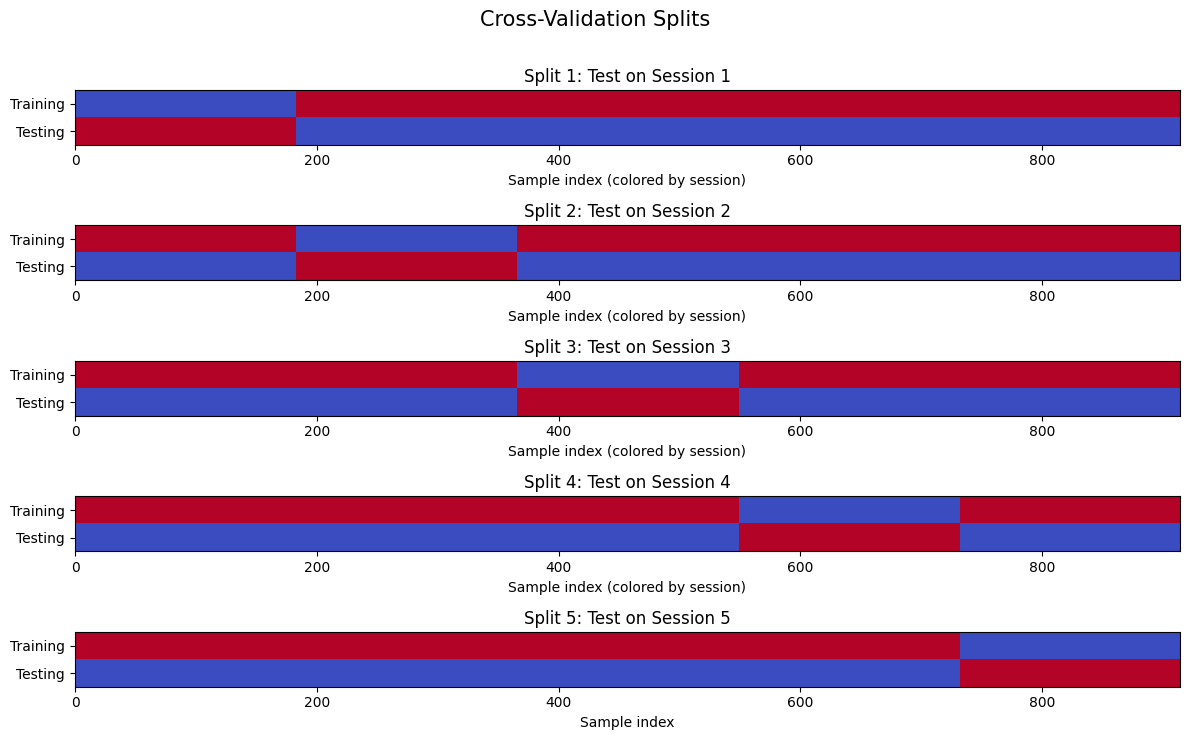

Testing on fold with 183 test samples...
Test RMSE: 10.1705
Test R²: -8999.0088


In [54]:

# --------------------------------------------------------------
# STEP 3: Try multi-session analysis with smaller window count
# --------------------------------------------------------------
def test_multisession_small():
    # Use all sessions but with fewer time samples
    sample_fraction = 0.2  # Use 20% of time samples
    overlap_percent = 50   # 50% overlap instead of 75%
    
    # Sample a fraction of the data
    samples_per_session = guided_X.shape[2]
    sample_size = int(samples_per_session * sample_fraction)
    
    X_sampled = np.zeros((guided_X.shape[0], guided_X.shape[1], sample_size), dtype=np.float32)
    y_sampled = np.zeros((guided_y.shape[0], guided_y.shape[1], sample_size), dtype=np.float32)
    
    for i in range(guided_X.shape[0]):
        X_sampled[i] = guided_X[i, :, :sample_size].astype(np.float32)
        y_sampled[i] = guided_y[i, :, :sample_size].astype(np.float32)
    
    print(f"Using {sample_fraction*100}% of time samples: X shape = {X_sampled.shape}")
    
    # Create windows with specified overlap
    X_windows, X_indices = create_windows_with_overlap(
        X_sampled, window_size=500, overlap_percent=overlap_percent)
    
    y_windows, _ = create_windows_with_overlap(
        y_sampled, window_size=500, overlap_percent=overlap_percent)
    
    print(f"Created {X_windows.shape[0]} windows")
    
    # Extract session indices for cross-validation
    session_indices = np.array([idx[0] for idx in X_indices])
    
    # Create cross-validator
    cv = LeaveOneSessionOut(n_sessions=5, session_indices=session_indices)
    
    # Visualize CV splits
    visualize_cv_splits(cv, X_windows, session_indices)
    
    # Test model on first fold only
    for train_idx, test_idx in cv.split(X_windows):
        print(f"Testing on fold with {len(test_idx)} test samples...")
        
        X_train, X_test = X_windows[train_idx], X_windows[test_idx]
        y_train, y_test = y_windows[train_idx], y_windows[test_idx]
        
        # Reshape y data
        y_train_reshaped = y_train.reshape(y_train.shape[0], -1)
        y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
        
        # Create and fit pipeline
        pipeline = Pipeline([
            ('features', EMGFeatureExtractor(features=['mav', 'rms', 'zc'])),
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0))
        ])
        
        pipeline.fit(X_train, y_train_reshaped)
        
        # Evaluate
        y_pred = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred))
        test_r2 = r2_score(y_test_reshaped, y_pred)
        
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        break  # Just test one fold
    
    # Memory cleanup
    del X_sampled, y_sampled, X_windows, y_windows
    gc.collect()

# Run this to test multiple sessions with small sample
test_multisession_small()

In [ ]:
# --------------------------------------------------------------
# STEP 4: Full pipeline with memory optimization
# --------------------------------------------------------------
def run_full_pipeline(sample_fraction=0.2, overlap_percent=50):
    """Run the full pipeline with memory optimization"""
    print("\n=== Running Full Pipeline ===")
    print(f"Sample fraction: {sample_fraction}, Overlap: {overlap_percent}%")
    
    # Sample a fraction of the data
    samples_per_session = guided_X.shape[2]
    sample_size = int(samples_per_session * sample_fraction)
    
    X_sampled = np.zeros((guided_X.shape[0], guided_X.shape[1], sample_size), dtype=np.float32)
    y_sampled = np.zeros((guided_y.shape[0], guided_y.shape[1], sample_size), dtype=np.float32)
    
    for i in range(guided_X.shape[0]):
        X_sampled[i] = guided_X[i, :, :sample_size].astype(np.float32)
        y_sampled[i] = guided_y[i, :, :sample_size].astype(np.float32)
    
    print(f"Using {sample_size} time samples per session")
    
    # Create windows with specified overlap
    X_windows, X_indices = create_windows_with_overlap(
        X_sampled, window_size=500, overlap_percent=overlap_percent)
    
    y_windows, _ = create_windows_with_overlap(
        y_sampled, window_size=500, overlap_percent=overlap_percent)
    
    print(f"Created {X_windows.shape[0]} windows")
    
    # Extract session indices for cross-validation
    session_indices = np.array([idx[0] for idx in X_indices])
    
    # Create cross-validator
    cv = LeaveOneSessionOut(n_sessions=5, session_indices=session_indices)
    
    # Reshape y windows
    y_reshaped = y_windows.reshape(y_windows.shape[0], -1)
    
    # Create and fit pipeline with memory efficient model
    pipeline = Pipeline([
        ('features', EMGFeatureExtractor(features=['mav', 'rms', 'zc'])),
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))  # Ridge uses less memory than RF
    ])
    
    # Free memory before cross-validation
    del X_sampled, y_sampled
    gc.collect()
    
    # Collect results across folds
    fold_rmse = []
    fold_r2 = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_windows)):
        print(f"\nFold {fold+1}: Testing on session {np.unique(session_indices[test_idx])[0]+1}")
        print(f"Training samples: {len(train_idx)}, Testing samples: {len(test_idx)}")
        
        X_train, X_test = X_windows[train_idx], X_windows[test_idx]
        y_train, y_test = y_reshaped[train_idx], y_reshaped[test_idx]
        
        # Fit model
        pipeline.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        
        fold_rmse.append(test_rmse)
        fold_r2.append(test_r2)
    
    # Overall results
    print("\n=== Cross-Validation Results ===")
    print(f"Mean RMSE: {np.mean(fold_rmse):.4f} ± {np.std(fold_rmse):.4f}")
    print(f"Mean R²: {np.mean(fold_r2):.4f} ± {np.std(fold_r2):.4f}")
    
    # Fit on full dataset for final model
    print("\nFitting final model on full dataset...")
    pipeline.fit(X_windows, y_reshaped)
    
    return pipeline

# Run this for full pipeline with memory optimization
# final_model = run_full_pipeline(sample_fraction=0.2, overlap_percent=50)


In [ ]:
# --------------------------------------------------------------
# STEP 5: Test Feature Importance (after successful pipeline run)
# --------------------------------------------------------------
def analyze_feature_importance(model_pipeline, feature_list=['mav', 'rms', 'zc']):
    """Analyze feature importance from the model"""
    # Extract the feature names
    feature_extractor = model_pipeline.named_steps['features']
    feature_names = feature_extractor.get_feature_names_out()
    
    # For Ridge regression, get coefficients
    if hasattr(model_pipeline.named_steps['regressor'], 'coef_'):
        coeffs = model_pipeline.named_steps['regressor'].coef_
        
        # Average absolute coefficient across all joint angles
        importance = np.mean(np.abs(coeffs), axis=0)
        
        # Sort features by importance
        indices = np.argsort(importance)[::-1]
        
        # Plot top features
        plt.figure(figsize=(12, 6))
        plt.title('Feature Importance based on Ridge Coefficients')
        plt.bar(range(20), importance[indices[:20]])
        plt.xticks(range(20), feature_names[indices[:20]], rotation=90)
        plt.tight_layout()
        plt.show()
        
        # Print top features
        print("Top 10 most important features:")
        for i in range(10):
            print(f"{i+1}. {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")
    else:
        print("The model doesn't have feature importance information.")

# Run this after model training is successful
# analyze_feature_importance(final_model)

Analyzing 3 sessions with 8 electrodes and 5 joint angles
Using 500 samples per session

Session 1 Statistics:
  EMG mean: -0.0169, std: 1.0135
  EMG min: -3.7574, max: 3.3981
  Electrode means: min=-0.0841, max=0.0588
  Joint angles mean: 0.0221, std: 0.9913

Session 2 Statistics:
  EMG mean: 0.0224, std: 0.9926
  EMG min: -3.5410, max: 3.7775
  Electrode means: min=-0.0472, max=0.0870
  Joint angles mean: -0.0283, std: 0.9679

Session 3 Statistics:
  EMG mean: 0.0045, std: 0.9964
  EMG min: -3.4416, max: 3.6875
  Electrode means: min=-0.0239, max=0.0430
  Joint angles mean: 0.0183, std: 0.9962

Training model for Session 1...
  Session 1 test - RMSE: 1.0118, R²: -0.0498

Training model for Session 2...
  Session 2 test - RMSE: 0.9770, R²: -0.0182

Training model for Session 3...
  Session 3 test - RMSE: 1.0031, R²: -0.0131

Testing cross-session performance:
  Model 1 → Session 1: RMSE=0.9871, R²=0.0068
  Model 1 → Session 2: RMSE=0.9757, R²=-0.0222
  Model 1 → Session 3: RMSE=1.0068

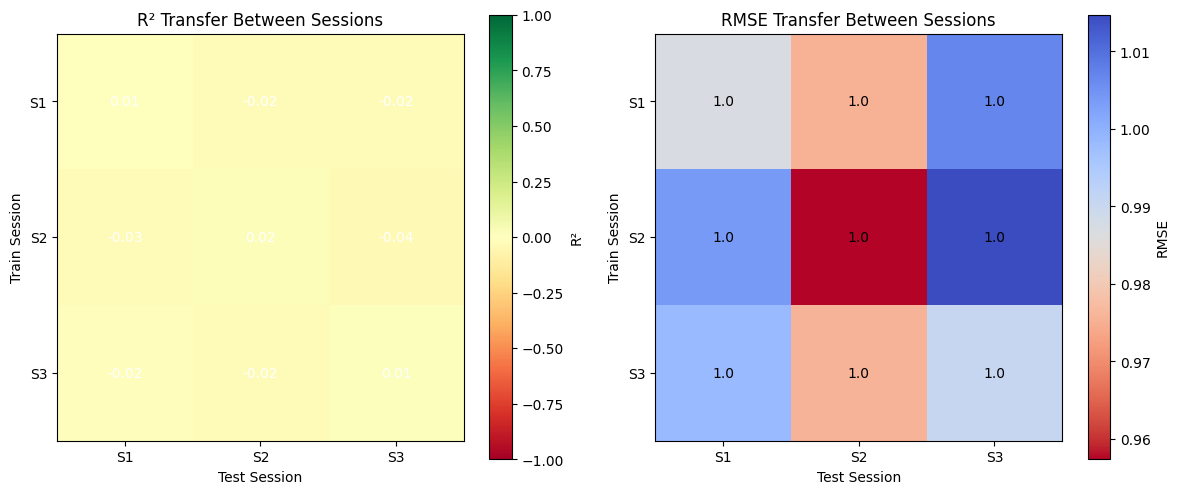


Analysis complete. A visualization of session transfer has been saved.
Function completed successfully!
Analyzing 5 sessions with 8 electrodes and 51 joint angles
Using 10000 samples per session

Session 1 Statistics:
  EMG mean: -0.5606, std: 74.4569
  EMG min: -1959.5582, max: 1864.6066
  Electrode means: min=-2.3468, max=2.5597
  Joint angles mean: -6.8080, std: 23.6947

Session 2 Statistics:
  EMG mean: -0.7060, std: 57.9316
  EMG min: -1611.6656, max: 1396.8729
  Electrode means: min=-2.4571, max=2.1516
  Joint angles mean: -7.7230, std: 24.9849

Session 3 Statistics:
  EMG mean: -0.6457, std: 74.6894
  EMG min: -1955.3883, max: 2607.9276
  Electrode means: min=-2.6092, max=2.5354
  Joint angles mean: -8.0650, std: 26.1639

Session 4 Statistics:
  EMG mean: -0.7225, std: 91.7138
  EMG min: -2397.5626, max: 1767.4525
  Electrode means: min=-2.4751, max=2.3968
  Joint angles mean: -5.8491, std: 21.6319

Session 5 Statistics:
  EMG mean: -0.8344, std: 109.6955
  EMG min: -2468.7720,

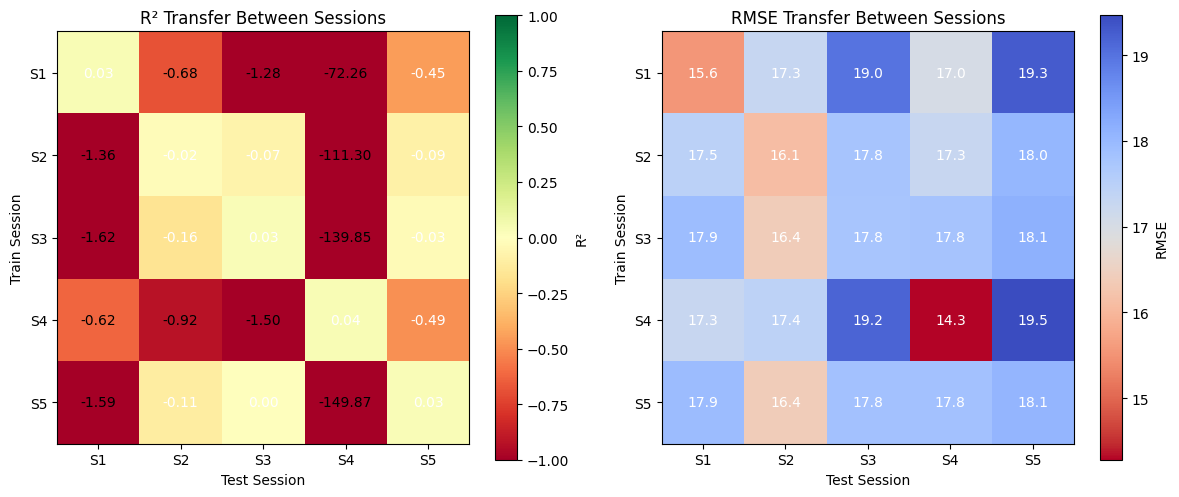


Analysis complete. A visualization of session transfer has been saved.


In [82]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def analyze_session_differences(guided_X, guided_y, max_samples=10000):
    """
    Very simple direct analysis of session differences.
    
    This function:
    1. Takes a small number of samples from each session
    2. Computes basic statistics to show differences between sessions
    3. Trains a simple model for each session
    4. Tests how well each session's model transfers to other sessions
    
    Parameters:
    -----------
    guided_X : numpy array
        EMG data (sessions, electrodes, time)
    guided_y : numpy array
        Joint angle data (sessions, joints, time)
    max_samples : int
        Maximum samples to use per session (to avoid memory issues)
    """
    n_sessions = guided_X.shape[0]
    n_electrodes = guided_X.shape[1]
    n_joints = guided_y.shape[1]
    
    print(f"Analyzing {n_sessions} sessions with {n_electrodes} electrodes and {n_joints} joint angles")
    
    # Extract a small number of samples from each session
    samples_per_session = min(max_samples, guided_X.shape[2])
    print(f"Using {samples_per_session} samples per session")
    
    X_data = []
    y_data = []
    
    for s in range(n_sessions):
        # Get sample data from this session
        X_session = guided_X[s, :, :samples_per_session].T  # Transpose to (samples, electrodes)
        y_session = guided_y[s, :, :samples_per_session].T  # Transpose to (samples, joints)
        
        X_data.append(X_session)
        y_data.append(y_session)
        
        # Print basic statistics for this session
        print(f"\nSession {s+1} Statistics:")
        print(f"  EMG mean: {np.mean(X_session):.4f}, std: {np.std(X_session):.4f}")
        print(f"  EMG min: {np.min(X_session):.4f}, max: {np.max(X_session):.4f}")
        
        # Compare electrode means
        electrode_means = np.mean(X_session, axis=0)
        print(f"  Electrode means: min={np.min(electrode_means):.4f}, max={np.max(electrode_means):.4f}")
        
        # Compare joint angle statistics
        print(f"  Joint angles mean: {np.mean(y_session):.4f}, std: {np.std(y_session):.4f}")
    
    # Create a simple model for each session
    models = []
    
    for s in range(n_sessions):
        print(f"\nTraining model for Session {s+1}...")
        
        # Create train/test split (80/20)
        split_idx = int(len(X_data[s]) * 0.8)
        X_train = X_data[s][:split_idx]
        y_train = y_data[s][:split_idx]
        X_test = X_data[s][split_idx:]
        y_test = y_data[s][split_idx:]
        
        # Create and fit a simple model
        model = Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', Ridge(alpha=1.0))
        ])
        
        model.fit(X_train, y_train)
        
        # Evaluate on this session's test data
        y_pred = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        
        print(f"  Session {s+1} test - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
        
        models.append(model)
    
    # Create a transfer matrix showing how well models transfer between sessions
    transfer_matrix_r2 = np.zeros((n_sessions, n_sessions))
    transfer_matrix_rmse = np.zeros((n_sessions, n_sessions))
    
    print("\nTesting cross-session performance:")
    
    for train_s in range(n_sessions):
        model = models[train_s]
        
        for test_s in range(n_sessions):
            # Get test data for this session
            X_test = X_data[test_s]
            y_test = y_data[test_s]
            
            # Predict using the model trained on train_s
            y_pred = model.predict(X_test)
            
            # Calculate performance metrics
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            test_r2 = r2_score(y_test, y_pred)
            
            # Store in transfer matrices
            transfer_matrix_r2[train_s, test_s] = test_r2
            transfer_matrix_rmse[train_s, test_s] = test_rmse
            
            print(f"  Model {train_s+1} → Session {test_s+1}: RMSE={test_rmse:.4f}, R²={test_r2:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # R² transfer matrix
    plt.subplot(1, 2, 1)
    plt.imshow(transfer_matrix_r2, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='R²')
    plt.title('R² Transfer Between Sessions')
    plt.xlabel('Test Session')
    plt.ylabel('Train Session')
    plt.xticks(np.arange(n_sessions), [f'S{i+1}' for i in range(n_sessions)])
    plt.yticks(np.arange(n_sessions), [f'S{i+1}' for i in range(n_sessions)])
    
    # Add text labels to cells
    for i in range(n_sessions):
        for j in range(n_sessions):
            plt.text(j, i, f"{transfer_matrix_r2[i, j]:.2f}", 
                     ha="center", va="center", 
                     color="white" if (transfer_matrix_r2[i, j] < 0.5 and 
                                       transfer_matrix_r2[i, j] > -0.5) else "black")
    
    # RMSE transfer matrix
    plt.subplot(1, 2, 2)
    plt.imshow(transfer_matrix_rmse, cmap='coolwarm_r')
    plt.colorbar(label='RMSE')
    plt.title('RMSE Transfer Between Sessions')
    plt.xlabel('Test Session')
    plt.ylabel('Train Session')
    plt.xticks(np.arange(n_sessions), [f'S{i+1}' for i in range(n_sessions)])
    plt.yticks(np.arange(n_sessions), [f'S{i+1}' for i in range(n_sessions)])
    
    # Add text labels to cells
    for i in range(n_sessions):
        for j in range(n_sessions):
            plt.text(j, i, f"{transfer_matrix_rmse[i, j]:.1f}", 
                     ha="center", va="center", 
                     color="white" if transfer_matrix_rmse[i, j] > 10 else "black")
    
    plt.tight_layout()
    plt.savefig('session_transfer_matrix.png')
    plt.show()
    
    print("\nAnalysis complete. A visualization of session transfer has been saved.")
    return transfer_matrix_r2, transfer_matrix_rmse, models

# Quick test to verify the function works
if __name__ == "__main__":
    # Create dummy data as a sanity check
    dummy_X = np.random.randn(3, 8, 1000)  # 3 sessions, 8 electrodes, 1000 samples
    dummy_y = np.random.randn(3, 5, 1000)  # 3 sessions, 5 joints, 1000 samples
    
    # Should print debugging information
    r2, rmse, models = analyze_session_differences(dummy_X, dummy_y, max_samples=500)
    print("Function completed successfully!")

# Use this function directly in your notebook:
r2_matrix, rmse_matrix, models = analyze_session_differences(guided_X, guided_y, max_samples=10000)